In [1]:
# load model from hf_cache
import os
from pathlib import Path

cache_dir = Path.cwd() / "hf_cache"
cache_dir.mkdir(exist_ok=True)
os.environ["HF_HOME"] = str(cache_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set dpi to 300
plt.rcParams['figure.dpi'] = 300

import openai
import json
import numpy as np
import random

from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
from copy import deepcopy
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
MODEL_NAME = "allenai/Olmo-3-7B-Instruct"

In [5]:
RANDOM_STATE = 42

In [6]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", cache_dir=cache_dir, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16).eval()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

`torch_dtype` is deprecated! Use `dtype` instead!
Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
def parse_answer(answer):
    answer_chunks = answer.strip().split(" ")
    for c in answer_chunks:
        if c == "A":
            return "A"
        elif c == "B":
            return "B"
    return "X"

In [8]:
def get_message(prompt, system_prompt=None):
    if system_prompt:
        return [{"role": "system", "content": system_prompt}, {"role": "user", "content": prompt}]
    else:
        return [{"role": "user", "content": prompt}]

def get_response(input):

    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."

    msg = get_message(input, system_prompt)
    input = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    gen = model.generate(**input, max_new_tokens=200, pad_token_id=tokenizer.eos_token_id, do_sample=False)
    return tokenizer.decode(gen[0][len(input.input_ids[0]):], skip_special_tokens=True)

In [9]:
df = pd.read_csv("Question_Subsets/certainty_effect_pairs.csv", index_col=0).reset_index()
df['control_resp_full'] = ''
df['treatment_resp_full'] = ''

df['control_resp'] = ''
df['treatment_resp'] = ''

In [10]:
for i in range(len(df)):
    control_text = df.iloc[i]['control_text']
    treatment_text = df.iloc[i]['treatment_text']

    control_resp = get_response(control_text)
    treatment_resp = get_response(treatment_text)

    df.at[i, 'control_resp_full'] = control_resp
    df.at[i, 'treatment_resp_full'] = treatment_resp

    df.at[i, 'control_resp'] = parse_answer(control_resp)
    df.at[i, 'treatment_resp'] = parse_answer(treatment_resp)

    print(i)
    print(control_resp)

    print(treatment_resp)
    print('---')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0
A
Option B
---
1
Option A
A
---
2
Option A
Option A
---
3
A
A
---
4
Option B
A
---
5
A
A
---
6
Option A
Option A
---
7
A
A
---
8
Option B
A
---
9
Option A
A
---
10
A
A
---
11
A
Option B
---
12
B
A
---
13
A
A
---
14
A
Option B
---
15
B
A
---
16
A
A
---
17
B
A
---
18
A
A
---
19
A
B
---
20
A
B
---
21
B
A
---
22
A
A
---
23
B
A
---
24
Option B
A
---
25
A
Option B
---
26
B
A
---
27
Option A
B
---
28
A
A
---
29
B
A
---
30
A
Option B
---
31
Option B
A
---
32
Option B
A
---
33
A
A
---
34
B
A
---
35
A
A
---
36
Option A
B
---
37
Option B
B
---
38
A
Option B
---
39
B
A
---
40
Option A
B
---
41
Option B
A
---
42
A
A
---
43
Option A
B
---
44
A
B
---
45
A
A
---
46
B
A
---
47
A
B
---
48
A
B
---
49
A
Option B
---
50
A
B
---
51
A
B
---
52
B
A
---
53
A
B
---
54
A
B
---
55
A
A
---
56
B
A
---
57
A
B
---
58
A
B
---
59
B
A
---
60
A
Option B
---
61
B
A
---
62
A
B
---
63
A
B
---
64
B
A
---
65
B
A
---
66
A
B
---
67
A
B
---
68
B
A
---
69
A
B
---
70
A
B
---
71
B
A
---
72
A
B
---
73
A
B
---
74
B
A
---
75
A
B
---

In [11]:
df['control_resp_eq_treatment_resp'] = df.control_resp == df.treatment_resp

In [13]:
df.to_csv('Question_Subsets/certainty_effect_pairs_with_answers.csv')

In [14]:
df_switch = df[df.control_resp != df.treatment_resp]

In [15]:
from sklearn.model_selection import train_test_split
df_switch_train, df_switch_test = train_test_split(df_switch, test_size=0.5, random_state=RANDOM_STATE)

In [16]:
df_switch_sample = df_switch.sample(10, random_state=RANDOM_STATE)

In [17]:
df_switch_sample.to_csv('Question_Subsets/certainty_effect_pairs_switch_sample.csv')

In [18]:
# =============================================================================
# WORKFLOW 1: STEERING VECTOR CREATION
# =============================================================================
# Goal: Create steering vectors by contrasting activations between control and 
# treatment lottery questions. The hypothesis is that the "certainty effect" 
# manifests as a specific direction in activation space that can be extracted
# and used to steer model behavior.
#
# Method:
# 1. For each question pair in df_switch_train, run the model on both prompts
# 2. Extract residual stream activations at each layer (at the last token position)
# 3. Compute the mean difference: steering_vector[layer] = mean(treatment - control)
# 4. These vectors represent the "certainty bias direction" at each layer

In [24]:
# Get model architecture info
num_layers = model.config.num_hidden_layers
hidden_size = model.config.hidden_size
print(f"Model has {num_layers} layers with hidden size {hidden_size}")

# Inspect actual module names to find the correct layer paths
print("\nSearching for layer module names...")
layer_module_names = []
for name, module in model.named_modules():
    # Look for transformer layer modules
    if 'layers.' in name and name.endswith(('.0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9')):
        # Check if this is a top-level layer (not a submodule like attention)
        parts = name.split('.')
        # Find patterns like "model.layers.0" or "transformer.h.0"
        if parts[-1].isdigit() and int(parts[-1]) < num_layers:
            potential_layer = name
            if potential_layer not in layer_module_names:
                layer_module_names.append(potential_layer)

# Also try a more direct search
all_module_names = [name for name, _ in model.named_modules()]
print(f"\nSample of module names: {all_module_names[:20]}")

# Find the layer prefix
layer_prefix = None
for name in all_module_names:
    if '.0.' in name or name.endswith('.0'):
        parts = name.rsplit('.0', 1)[0]
        if 'layer' in parts.lower() or 'block' in parts.lower() or parts.endswith('h'):
            layer_prefix = parts
            break

print(f"\nDetected layer prefix: {layer_prefix}")
print(f"Example layer names: {layer_prefix}.0, {layer_prefix}.1, ...")

Model has 32 layers with hidden size 4096

Searching for layer module names...

Sample of module names: ['', 'model', 'model.embed_tokens', 'model.layers', 'model.layers.0', 'model.layers.0.self_attn', 'model.layers.0.self_attn.q_proj', 'model.layers.0.self_attn.k_proj', 'model.layers.0.self_attn.v_proj', 'model.layers.0.self_attn.o_proj', 'model.layers.0.self_attn.q_norm', 'model.layers.0.self_attn.k_norm', 'model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.post_attention_layernorm', 'model.layers.0.post_feedforward_layernorm', 'model.layers.1']

Detected layer prefix: model.layers
Example layer names: model.layers.0, model.layers.1, ...


In [25]:
from baukit import TraceDict

# Set LAYER_PREFIX based on inspection above - update if needed after running the cell above
# Common patterns: "model.layers", "model.model.layers", "transformer.h"
LAYER_PREFIX = layer_prefix  # Will be set by the inspection cell

def get_activations(prompt, layers_to_trace=None):
    """
    Extract residual stream activations at specified layers.
    
    Args:
        prompt: The text prompt to process
        layers_to_trace: List of layer indices to trace. If None, traces all layers.
    
    Returns:
        Dictionary mapping layer index -> activation tensor at last token position
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    
    if layers_to_trace is None:
        layers_to_trace = list(range(num_layers))
    
    # Build list of module names to trace using detected prefix
    layer_names = [f"{LAYER_PREFIX}.{i}" for i in layers_to_trace]
    
    activations = {}
    
    with torch.no_grad():
        # Use baukit TraceDict to capture activations from multiple layers
        with TraceDict(model, layer_names, retain_input=False, retain_output=True) as tr:
            outputs = model(**inputs, output_hidden_states=True)
        
        # Extract the output of each traced layer at the last token position
        for i, layer_idx in enumerate(layers_to_trace):
            layer_output = tr[layer_names[i]].output
            # layer_output is typically (hidden_states, ...) tuple or just hidden_states
            if isinstance(layer_output, tuple):
                hidden_states = layer_output[0]  # Shape: [batch, seq_len, hidden_size]
            else:
                hidden_states = layer_output
            # Get last token activation
            last_token_activation = hidden_states[0, -1, :].clone()
            activations[layer_idx] = last_token_activation
    
    return activations

print(f"Using LAYER_PREFIX: {LAYER_PREFIX}")

Using LAYER_PREFIX: model.layers


In [56]:
# Collect activation differences for each layer across all training pairs
# This will be used to compute the mean steering vector per layer

control_activations_list = {layer: [] for layer in range(num_layers)}
treatment_activations_list = {layer: [] for layer in range(num_layers)}

print(f"Processing {len(df_switch_train)} question pairs from df_switch_train...")

for idx, row in tqdm(df_switch_train.iterrows(), total=len(df_switch_train)):
    control_text = row['control_text']
    treatment_text = row['treatment_text']
    
    # Get activations for both control and treatment prompts
    control_acts = get_activations(control_text)
    treatment_acts = get_activations(treatment_text)
    
    # Store activations for each layer
    for layer in range(num_layers):
        control_activations_list[layer].append(control_acts[layer])
        treatment_activations_list[layer].append(treatment_acts[layer])

Processing 49 question pairs from df_switch_train...


100%|██████████| 49/49 [00:04<00:00, 11.40it/s]


In [57]:
# Compute steering vectors: mean(treatment - control) for each layer
# The steering vector represents the direction in activation space that 
# corresponds to the "certainty bias" - i.e., the shift that occurs when 
# a certain option is presented

steering_vectors = {}

for layer in range(num_layers):
    # Stack all activations for this layer
    control_stack = torch.stack(control_activations_list[layer])  # [n_samples, hidden_size]
    treatment_stack = torch.stack(treatment_activations_list[layer])
    
    # Compute mean difference: treatment - control
    # Positive direction = toward certainty bias
    mean_diff = (treatment_stack - control_stack).mean(dim=0)
    steering_vectors[layer] = mean_diff
    
print(f"Created {len(steering_vectors)} steering vectors (one per layer)")
print(f"Each steering vector has shape: {steering_vectors[0].shape}")

Created 32 steering vectors (one per layer)
Each steering vector has shape: torch.Size([4096])


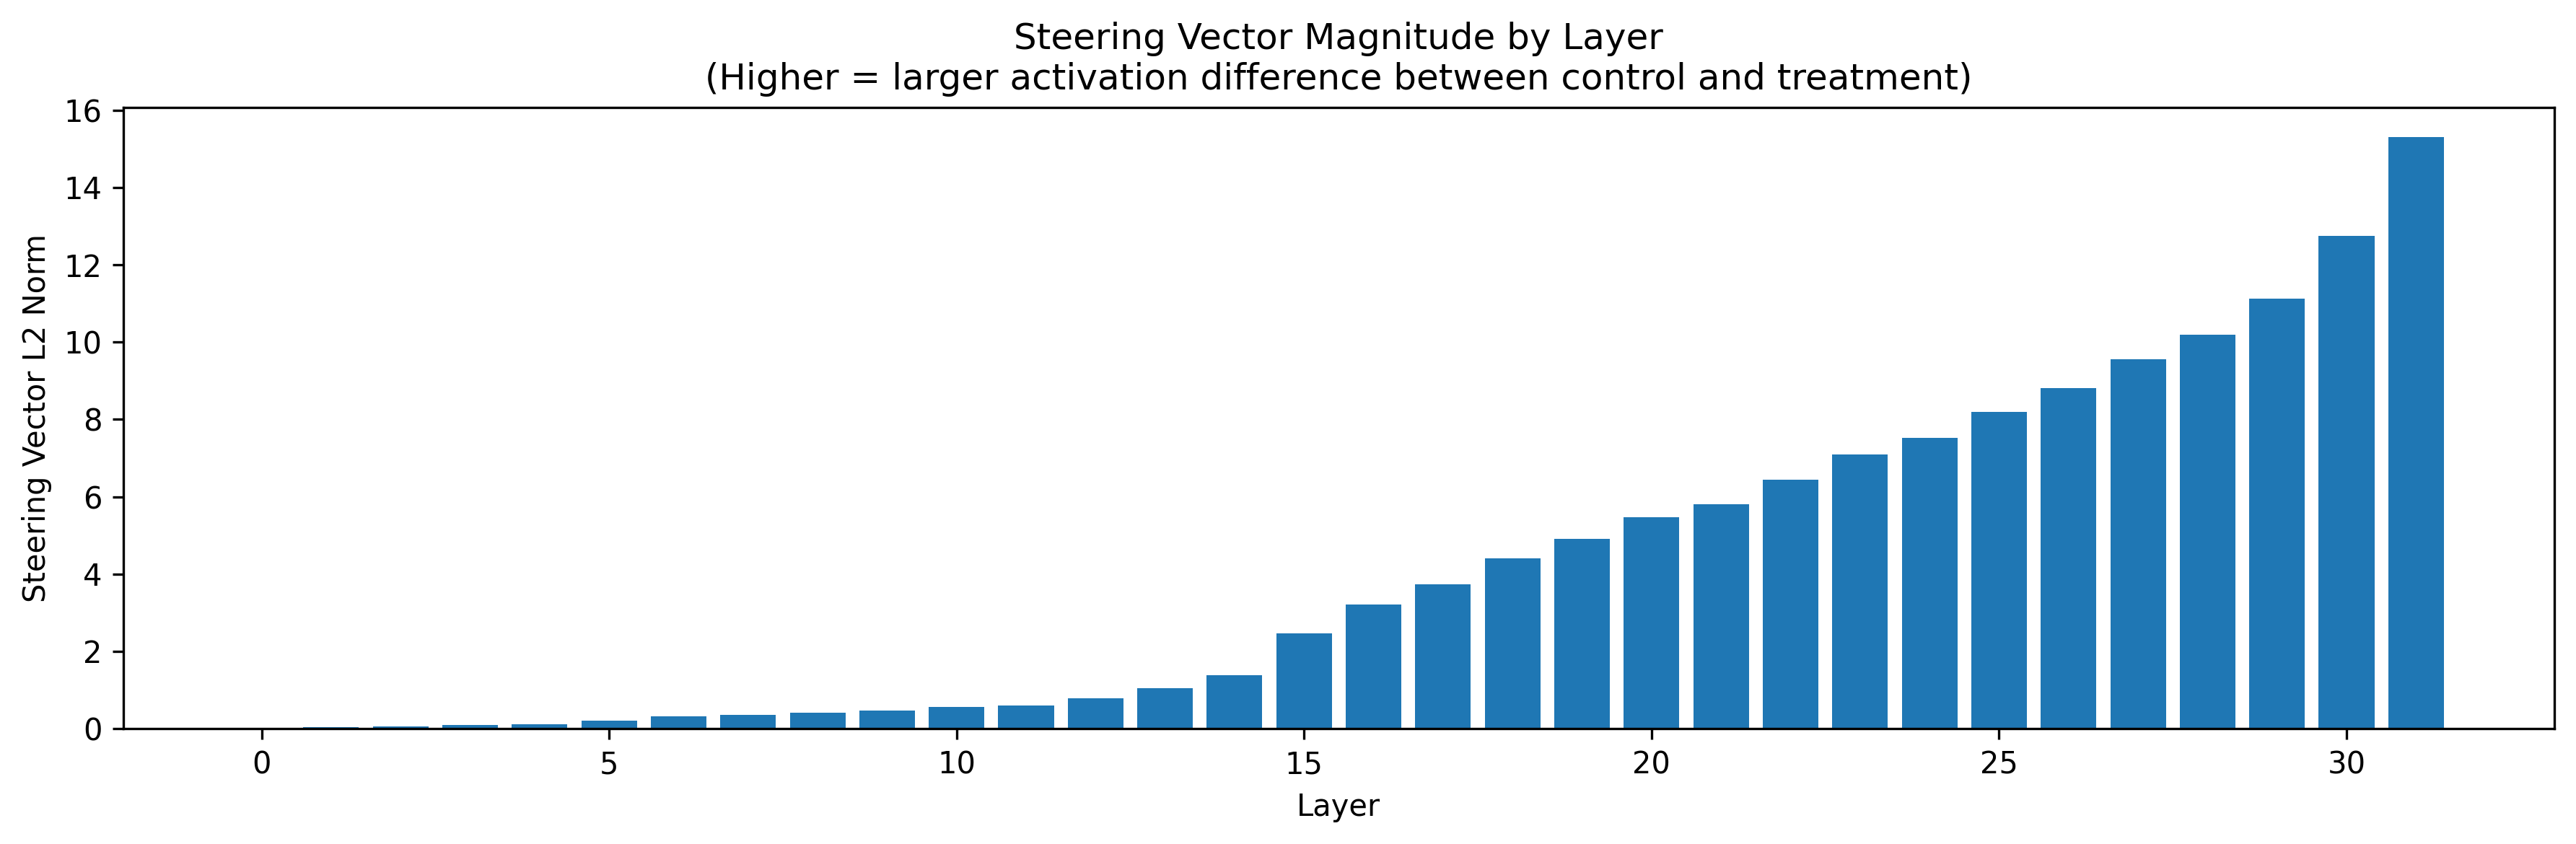


Top 5 layers by steering vector magnitude: [31, 30, 29, 28, 27]


In [58]:
# Analyze steering vector magnitudes across layers
# Larger magnitudes suggest layers where control vs treatment differ more

steering_norms = [steering_vectors[layer].norm().item() for layer in range(num_layers)]

plt.figure(figsize=(12, 4))
plt.bar(range(num_layers), steering_norms)
plt.xlabel("Layer")
plt.ylabel("Steering Vector L2 Norm")
plt.title("Steering Vector Magnitude by Layer\n(Higher = larger activation difference between control and treatment)")
plt.tight_layout()
plt.show()

# Find layers with strongest steering signal
top_layers = np.argsort(steering_norms)[::-1][:5]
print(f"\nTop 5 layers by steering vector magnitude: {top_layers.tolist()}")

In [59]:
# Save steering vectors for later use
torch.save(steering_vectors, 'steering_vectors_certainty.pt')
print("Saved steering vectors to steering_vectors_certainty.pt")

Saved steering vectors to steering_vectors_certainty.pt


In [20]:
# open steering_vectors_certainty.pt
steering_vectors = torch.load('steering_vectors_certainty.pt')

In [21]:
# Function to get response with steering applied at a specific layer
def get_steered_response(prompt, layer_to_steer, steering_vector, steering_strength=1.0):
    """
    Generate a response while adding a steering vector to a specific layer's activations.
    
    Args:
        prompt: Input text
        layer_to_steer: Which layer index to add the steering vector to
        steering_vector: The steering vector to add
        steering_strength: Multiplier for the steering vector (can be negative to steer opposite direction)
    
    Returns:
        Generated response text
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    
    layer_name = f"{LAYER_PREFIX}.{layer_to_steer}"
    
    # Create a hook function that adds the steering vector
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
            # Add steering vector to all positions (or just last token)
            hidden_states[:, -1, :] += steering_strength * steering_vector.to(hidden_states.dtype)
            return (hidden_states,) + output[1:]
        else:
            output[:, -1, :] += steering_strength * steering_vector.to(output.dtype)
            return output
    
    # Register the hook
    layer_module = dict(model.named_modules())[layer_name]
    hook_handle = layer_module.register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            gen = model.generate(**inputs, max_new_tokens=200, pad_token_id=tokenizer.eos_token_id, do_sample=False)
        response = tokenizer.decode(gen[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
    finally:
        hook_handle.remove()
    
    return response

In [22]:
# Test steering on held-out examples from df_switch_test
# We'll try steering the control question toward certainty bias (positive direction)
# and steering the treatment question away from certainty bias (negative direction)

# Pick a test example
test_idx = 3
test_example = df_switch_test.iloc[test_idx]
control_text = test_example['control_text']
treatment_text = test_example['treatment_text']

print("=" * 80)
print("TEST EXAMPLE")
print("=" * 80)
print(f"\nCONTROL prompt:\n{control_text}")
print(f"\nTREATMENT prompt:\n{treatment_text}")
print(f"\nOriginal control response: {test_example['control_resp']}")
print(f"Original treatment response: {test_example['treatment_resp']}")

TEST EXAMPLE

CONTROL prompt:
Choose between:
Option A - 30% to win $4000, 70% to win $0.
Option B - $5000 with a 25% chance, $0 with a 75% chance.
What is your choice?
Answer:

TREATMENT prompt:
Choose between:
Option A - $4000 for sure.
Option B - $5000 with a 85% chance, $0 with a 15% chance.
What is your choice?
Answer:

Original control response: B
Original treatment response: A


In [26]:
# Test steering at different layers and strengths
# Using top layers by steering magnitude

print("\n" + "=" * 80)
print("STEERING EXPERIMENTS")
print("=" * 80)

# Test on control prompt: can we induce certainty bias by adding steering vector?
print("\n--- Steering CONTROL prompt toward certainty (adding steering vector) ---")
for layer in range(num_layers):
    for strength in [0.5, 1.0, 2.0]:
        steered_resp = get_steered_response(control_text, layer, steering_vectors[layer], strength)
        print(f"Layer {layer}, strength {strength}: {parse_answer(steered_resp)} (full: {steered_resp[:50]})")

# Test on treatment prompt: can we reduce certainty bias by subtracting steering vector?
print("\n--- Steering TREATMENT prompt away from certainty (subtracting steering vector) ---")
for layer in range(num_layers):
    for strength in [-0.5, -1.0, -2.0]:
        steered_resp = get_steered_response(treatment_text, layer, steering_vectors[layer], strength)
        print(f"Layer {layer}, strength {strength}: {parse_answer(steered_resp)} (full: {steered_resp[:50]})")


STEERING EXPERIMENTS

--- Steering CONTROL prompt toward certainty (adding steering vector) ---
Layer 0, strength 0.5: B (full: Option B)
Layer 0, strength 1.0: B (full: Option B)
Layer 0, strength 2.0: B (full: Option B)
Layer 1, strength 0.5: B (full: Option B)
Layer 1, strength 1.0: B (full: Option B)
Layer 1, strength 2.0: B (full: B)
Layer 2, strength 0.5: B (full: Option B)
Layer 2, strength 1.0: B (full: Option B)
Layer 2, strength 2.0: B (full: Option B)
Layer 3, strength 0.5: B (full: Option B)
Layer 3, strength 1.0: B (full: Option B)
Layer 3, strength 2.0: B (full: Option B)
Layer 4, strength 0.5: B (full: Option B)
Layer 4, strength 1.0: B (full: Option B)
Layer 4, strength 2.0: B (full: Option B)
Layer 5, strength 0.5: B (full: Option B)
Layer 5, strength 1.0: B (full: Option B)
Layer 5, strength 2.0: B (full: Option B)
Layer 6, strength 0.5: B (full: Option B)
Layer 6, strength 1.0: B (full: B)
Layer 6, strength 2.0: B (full: B)
Layer 7, strength 0.5: B (full: Option B)


In [27]:
# =============================================================================
# WORKFLOW 2: ACTIVATION PATCHING
# =============================================================================
# 
# WHAT IS ACTIVATION PATCHING?
# Activation patching (also called "causal tracing" or "interchange intervention")
# is a technique to identify which specific activations are causally responsible 
# for a model's behavior.
#
# The key idea:
# 1. Run the model on prompt A (e.g., control) and cache its activations
# 2. Run the model on prompt B (e.g., treatment) but REPLACE specific activations
#    (at certain layers/positions) with the cached activations from prompt A
# 3. Observe if the output changes - if it does, those activations were causally
#    important for the behavioral difference
#
# In our context:
# - The model answers "A" for control but "B" for treatment (certainty effect)
# - Question: Which layer(s) and position(s) are responsible for this switch?
# - Experiment: Run treatment, but patch in control activations at various points
# - If patching layer L makes treatment behave like control, then layer L is
#   causally responsible for the certainty effect
#
# This is more rigorous than just looking at activation differences because:
# - Correlational: "activations differ at layer L" doesn't prove causation
# - Causal: "patching layer L changes behavior" proves those activations matter

In [31]:
# Select one question pair for the activation patching experiment
# We'll use the first example from df_switch_train

patch_example = df_switch_train.iloc[0]
control_prompt = patch_example['control_text']
treatment_prompt = patch_example['treatment_text']

print("ACTIVATION PATCHING EXAMPLE")
print("=" * 80)
print(f"\nControl prompt:\n{control_prompt}")
print(f"\nTreatment prompt:\n{treatment_prompt}")
print(f"\nControl response: {patch_example['control_resp']}")
print(f"Treatment response: {patch_example['treatment_resp']}")

ACTIVATION PATCHING EXAMPLE

Control prompt:
Choose between:
Option A - $1000 with a 20% chance, $0 with a 80% chance.
Option B - $800 with a 21% chance, $0 with a 79% chance.
What is your choice?
Answer:

Treatment prompt:
Choose between:
Option A - $1000 with a 20% chance, $800 with a 79% chance, $0 with a 1% chance.
Option B - $800 with certainty.
What is your choice?
Answer:

Control response: A
Treatment response: B


In [32]:
def cache_all_activations(prompt):
    """
    Run the model on a prompt and cache ALL layer activations at ALL token positions.
    
    Returns:
        Dictionary: layer_idx -> tensor of shape [seq_len, hidden_size]
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    
    layer_names = [f"{LAYER_PREFIX}.{i}" for i in range(num_layers)]
    cached = {}
    
    with torch.no_grad():
        # Use TraceDict for multiple layers
        with TraceDict(model, layer_names, retain_input=False, retain_output=True) as tr:
            outputs = model(**inputs)
        
        for layer_idx in range(num_layers):
            layer_output = tr[layer_names[layer_idx]].output
            if isinstance(layer_output, tuple):
                hidden_states = layer_output[0]
            else:
                hidden_states = layer_output
            # Store full sequence: [seq_len, hidden_size]
            cached[layer_idx] = hidden_states[0].clone()
    
    return cached, inputs.input_ids.shape[1]


def run_with_patching(prompt, cached_activations, layers_to_patch, positions_to_patch="last"):
    """
    Run model on a prompt but replace activations at specified layers/positions
    with cached activations from another prompt.
    
    Args:
        prompt: The prompt to run (e.g., treatment)
        cached_activations: Cached activations from another prompt (e.g., control)
        layers_to_patch: List of layer indices to patch
        positions_to_patch: "last" for last token, "all" for all tokens, or list of indices
    
    Returns:
        Model's generated response
    """
    system_prompt = "You are a helpful assistant. Answer shortly with only your choice with no explanation."
    msg = get_message(prompt, system_prompt)
    inputs = tokenizer.apply_chat_template(msg, return_tensors="pt", add_generation_prompt=True, return_dict=True).to(device)
    
    hooks = []
    
    for layer_idx in layers_to_patch:
        layer_name = f"{LAYER_PREFIX}.{layer_idx}"
        cached_act = cached_activations[layer_idx]
        
        def make_patch_hook(cached, positions):
            def hook(module, input, output):
                if isinstance(output, tuple):
                    hidden_states = output[0].clone()
                    if positions == "last":
                        # Patch last token only
                        hidden_states[0, -1, :] = cached[-1, :].to(hidden_states.dtype)
                    elif positions == "all":
                        # Patch all positions (use min of seq lengths)
                        min_len = min(hidden_states.shape[1], cached.shape[0])
                        hidden_states[0, :min_len, :] = cached[:min_len, :].to(hidden_states.dtype)
                    else:
                        # Patch specific positions
                        for pos in positions:
                            if pos < hidden_states.shape[1] and pos < cached.shape[0]:
                                hidden_states[0, pos, :] = cached[pos, :].to(hidden_states.dtype)
                    return (hidden_states,) + output[1:]
                else:
                    if positions == "last":
                        output[0, -1, :] = cached[-1, :].to(output.dtype)
                    elif positions == "all":
                        min_len = min(output.shape[1], cached.shape[0])
                        output[0, :min_len, :] = cached[:min_len, :].to(output.dtype)
                    return output
            return hook
        
        layer_module = dict(model.named_modules())[layer_name]
        handle = layer_module.register_forward_hook(make_patch_hook(cached_act, positions_to_patch))
        hooks.append(handle)
    
    try:
        with torch.no_grad():
            gen = model.generate(**inputs, max_new_tokens=200, pad_token_id=tokenizer.eos_token_id, do_sample=False)
        response = tokenizer.decode(gen[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
    finally:
        for h in hooks:
            h.remove()
    
    return response

In [33]:
# Step 1: Cache activations from the control prompt
print("Caching activations from control prompt...")
control_cached, control_seq_len = cache_all_activations(control_prompt)
print(f"Cached activations for {len(control_cached)} layers, sequence length {control_seq_len}")

Caching activations from control prompt...
Cached activations for 32 layers, sequence length 82


In [34]:
# Step 2: Run treatment with patching at each layer individually
# This identifies which layer(s) are causally responsible for the behavioral difference

print("\n" + "=" * 80)
print("LAYER-BY-LAYER PATCHING: Treatment + Control activations at layer L")
print("=" * 80)
print(f"Baseline treatment response: {patch_example['treatment_resp']}")
print(f"Target (control) response: {patch_example['control_resp']}")
print("-" * 80)

patching_results = []

for layer in tqdm(range(num_layers)):
    patched_resp = run_with_patching(treatment_prompt, control_cached, [layer], "last")
    parsed = parse_answer(patched_resp)
    patching_results.append({
        'layer': layer,
        'response': parsed,
        'full_response': patched_resp[:50],
        'flipped': parsed == patch_example['control_resp']
    })

# Show results
df_patch_results = pd.DataFrame(patching_results)
print("\nPatching results (showing layers where response flipped to control's answer):")
flipped_layers = df_patch_results[df_patch_results['flipped']]
if len(flipped_layers) > 0:
    print(flipped_layers)
else:
    print("No individual layer patching caused a flip.")


LAYER-BY-LAYER PATCHING: Treatment + Control activations at layer L
Baseline treatment response: B
Target (control) response: A
--------------------------------------------------------------------------------


100%|██████████| 32/32 [02:09<00:00,  4.04s/it]


Patching results (showing layers where response flipped to control's answer):
No individual layer patching caused a flip.


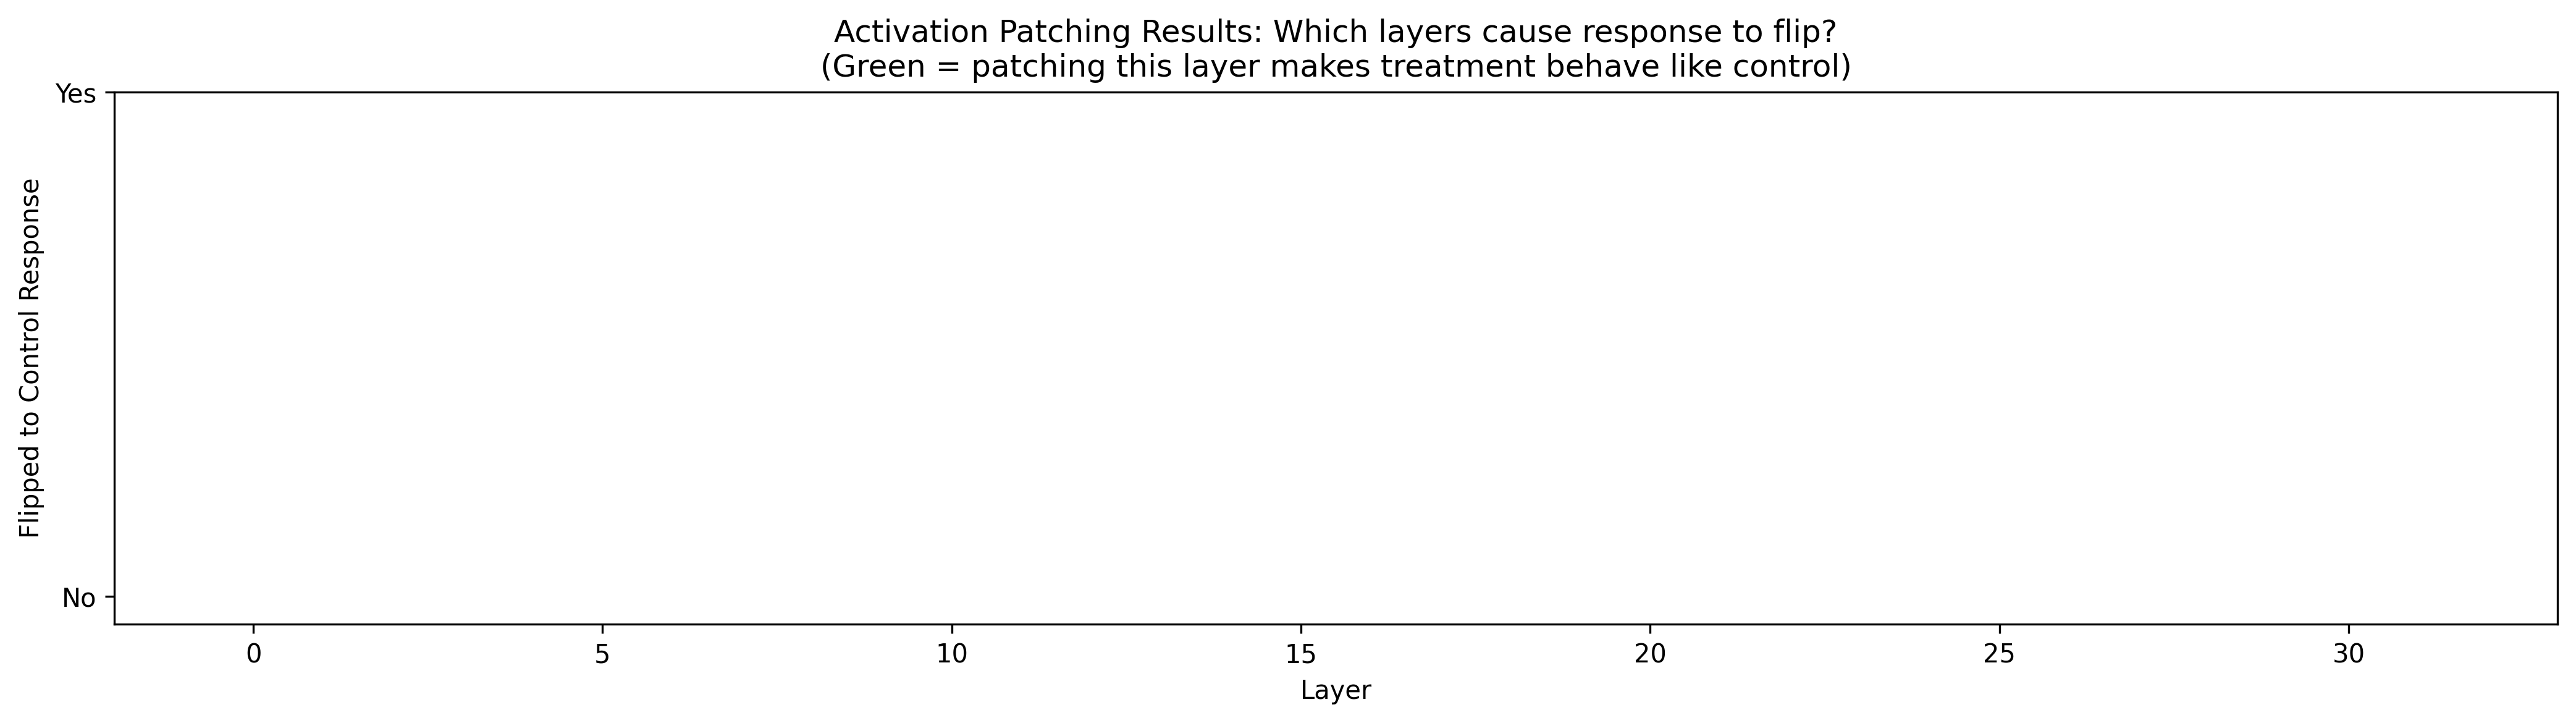


Summary: Patching at 0 out of 32 layers flipped the response.


In [81]:
# Visualize patching results
# Show which layers, when patched, flip the response

plt.figure(figsize=(14, 4))

# Create a binary indicator: 1 if flipped to control, 0 otherwise
flip_indicator = [1 if r['flipped'] else 0 for r in patching_results]

plt.bar(range(num_layers), flip_indicator, color=['green' if f else 'lightgray' for f in flip_indicator])
plt.xlabel("Layer")
plt.ylabel("Flipped to Control Response")
plt.title("Activation Patching Results: Which layers cause response to flip?\n(Green = patching this layer makes treatment behave like control)")
plt.yticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

print(f"\nSummary: Patching at {sum(flip_indicator)} out of {num_layers} layers flipped the response.")

In [82]:
# Advanced patching: Patch ranges of layers to find the critical window
# Sometimes a single layer isn't enough - we need to patch a contiguous range

print("\n" + "=" * 80)
print("RANGE PATCHING: Find critical layer windows")
print("=" * 80)

# Try patching layers [start:start+window_size] for various starts and sizes
window_sizes = [3, 5, 7]
range_results = []

for window_size in window_sizes:
    print(f"\nTesting window size {window_size}...")
    for start_layer in range(0, num_layers - window_size + 1, 2):  # step by 2 for efficiency
        layers_to_patch = list(range(start_layer, start_layer + window_size))
        patched_resp = run_with_patching(treatment_prompt, control_cached, layers_to_patch, "last")
        parsed = parse_answer(patched_resp)
        range_results.append({
            'window_size': window_size,
            'start_layer': start_layer,
            'end_layer': start_layer + window_size - 1,
            'response': parsed,
            'flipped': parsed == patch_example['control_resp']
        })

df_range_results = pd.DataFrame(range_results)
print("\nRange patching results (showing ranges that flipped the response):")
flipped_ranges = df_range_results[df_range_results['flipped']]
if len(flipped_ranges) > 0:
    print(flipped_ranges[['window_size', 'start_layer', 'end_layer', 'response']])
else:
    print("No layer ranges caused a flip.")


RANGE PATCHING: Find critical layer windows

Testing window size 3...

Testing window size 5...

Testing window size 7...

Range patching results (showing ranges that flipped the response):
No layer ranges caused a flip.


In [35]:
# =============================================================================
# INTERPRETATION GUIDE
# =============================================================================
#
# STEERING VECTORS:
# - The steering vectors capture the average direction in activation space
#   that separates control from treatment responses
# - Layers with larger steering vector norms show bigger differences
# - You can use these vectors to:
#   1. Steer model behavior at inference time (add/subtract from activations)
#   2. Analyze which dimensions encode certainty preference
#   3. Compare across different models or question types
#
# ACTIVATION PATCHING:
# - Single-layer patching shows if any individual layer is sufficient to flip behavior
# - Range patching reveals if multiple layers must be patched together
# - Early layers (0-10) often encode input features and syntax
# - Middle layers (10-20) often encode semantic/conceptual representations
# - Late layers (20+) often encode output-related decisions
#
# If patching late layers flips behavior: the decision happens late, possibly in
# how the model converts its understanding into a specific answer choice
#
# If patching middle layers flips behavior: the certainty effect operates at a
# conceptual level, affecting how the model reasons about the options
#
# If no single layer works but ranges do: the effect is distributed across
# multiple layers working together
#
# NEXT STEPS:
# 1. Run steering on df_switch_test to evaluate generalization
# 2. Try patching at different token positions (not just last token)
# 3. Extend to attention heads (finer-grained than full layers)
# 4. Compare patching effects across multiple question pairs

In [36]:
# =============================================================================
# OPTIONAL: Evaluate steering vectors on test set
# =============================================================================
# This evaluates whether the steering vectors generalize to held-out examples

def evaluate_steering_on_test(test_df, layer, steering_vec, strength):
    """
    Evaluate steering effectiveness on test set.
    Returns the fraction of treatment prompts where steering flipped the response.
    """
    flipped_count = 0
    for idx, row in test_df.iterrows():
        treatment_text = row['treatment_text']
        original_resp = row['treatment_resp']
        target_resp = row['control_resp']
        
        # Apply steering (negative strength to steer away from certainty bias)
        steered_resp = get_steered_response(treatment_text, layer, steering_vec, strength)
        steered_parsed = parse_answer(steered_resp)
        
        if steered_parsed == target_resp and original_resp != target_resp:
            flipped_count += 1
    
    return flipped_count / len(test_df)

# Uncomment below to run test set evaluation (can be slow)
# print("Evaluating steering vectors on test set...")
# for layer in top_layers[:3]:
#     for strength in [-1.0, -2.0]:
#         flip_rate = evaluate_steering_on_test(df_switch_test, layer, steering_vectors[layer], strength)
#         print(f"Layer {layer}, strength {strength}: {flip_rate:.1%} of responses flipped")

In [37]:
def evaluate_steering_on_test(test_df, layer, steering_vec, strength):
    """
    Evaluate steering effectiveness on test set.
    Returns a DataFrame with all responses (original and steered) plus a flip rate.
    """
    results = []

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        treatment_text = row['treatment_text']
        control_text = row['control_text']
        original_treatment_resp = row['treatment_resp']
        original_control_resp = row['control_resp']

        # Apply steering (negative strength to steer away from certainty bias)
        steered_resp_full = get_steered_response(treatment_text, layer, steering_vec, strength)
        steered_resp_parsed = parse_answer(steered_resp_full)

        # Check if it flipped to control's answer
        flipped = (steered_resp_parsed == original_control_resp and
                   original_treatment_resp != original_control_resp)

        results.append({
            'index': idx,
            'control_text': control_text,
            'treatment_text': treatment_text,
            'original_control_resp': original_control_resp,
            'original_treatment_resp': original_treatment_resp,
            'steered_resp_full': steered_resp_full,
            'steered_resp_parsed': steered_resp_parsed,
            'layer': layer,
            'strength': strength,
            'flipped_to_control': flipped
        })

    results_df = pd.DataFrame(results)
    flip_rate = results_df['flipped_to_control'].mean()

    return results_df, flip_rate


def run_steering_evaluation(test_df, layers_to_test, steering_vectors, strengths, save_path=None):
    """
    Run full steering evaluation across multiple layers and strengths.
    """
    all_results = []

    for layer in layers_to_test:
        for strength in strengths:
            print(f"Evaluating layer {layer}, strength {strength}...")
            results_df, flip_rate = evaluate_steering_on_test(
                test_df, layer, steering_vectors[layer], strength
            )
            all_results.append(results_df)
            print(f"  Flip rate: {flip_rate:.1%}")

    combined_df = pd.concat(all_results, ignore_index=True)

    if save_path:
        combined_df.to_csv(save_path, index=False)
        print(f"\nSaved results to {save_path}")

    return combined_df

In [39]:
print("Evaluating steering vectors on test set...")
steering_results = run_steering_evaluation(
    test_df=df_switch_test,
    layers_to_test=list(range(num_layers)),
    steering_vectors=steering_vectors,
    strengths=[-2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0],
    save_path='steering_evaluation_results.csv'
)

# Summary by layer and strength
print("\nSummary (flip rate by layer and strength):")
print(steering_results.groupby(['layer', 'strength'])['flipped_to_control'].mean())

Evaluating steering vectors on test set...
Evaluating layer 0, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 2.0%
Evaluating layer 0, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.13it/s]


  Flip rate: 2.0%
Evaluating layer 0, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.16it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.15it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 0, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.34it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


  Flip rate: 0.0%
Evaluating layer 1, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.14it/s]


  Flip rate: 2.0%
Evaluating layer 1, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 2.0%
Evaluating layer 2, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 2, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 2.0%
Evaluating layer 3, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.95it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 2.0%
Evaluating layer 3, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 3, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 4, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 4.0%
Evaluating layer 5, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 4.0%
Evaluating layer 5, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


  Flip rate: 2.0%
Evaluating layer 5, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 0.0%
Evaluating layer 5, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 6, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 2.0%
Evaluating layer 6, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 6, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.11it/s]


  Flip rate: 2.0%
Evaluating layer 7, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.32it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.32it/s]


  Flip rate: 0.0%
Evaluating layer 7, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 8, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.70it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.73it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.94it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.91it/s]


  Flip rate: 0.0%
Evaluating layer 8, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.12it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


  Flip rate: 2.0%
Evaluating layer 8, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


  Flip rate: 0.0%
Evaluating layer 8, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 2.0%
Evaluating layer 9, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 9, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 9, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.09it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 9, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.10it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.90it/s]


  Flip rate: 2.0%
Evaluating layer 10, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 2.0%
Evaluating layer 10, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 10, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 2.0%
Evaluating layer 11, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.28it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 2.0%
Evaluating layer 11, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


  Flip rate: 2.0%
Evaluating layer 11, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 0.0%
Evaluating layer 11, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 4.0%
Evaluating layer 11, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.64it/s]


  Flip rate: 6.0%
Evaluating layer 12, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.08it/s]


  Flip rate: 4.0%
Evaluating layer 12, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 4.0%
Evaluating layer 12, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 2.0%
Evaluating layer 12, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 12, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 13, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.72it/s]


  Flip rate: 12.0%
Evaluating layer 13, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.71it/s]


  Flip rate: 8.0%
Evaluating layer 13, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.48it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.70it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 13, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


  Flip rate: 2.0%
Evaluating layer 13, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.68it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.30it/s]


  Flip rate: 4.0%
Evaluating layer 13, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.30it/s]


  Flip rate: 6.0%
Evaluating layer 14, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.70it/s]


  Flip rate: 24.0%
Evaluating layer 14, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.51it/s]


  Flip rate: 22.0%
Evaluating layer 14, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


  Flip rate: 14.0%
Evaluating layer 14, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 6.0%
Evaluating layer 14, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 14, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.46it/s]


  Flip rate: 32.0%
Evaluating layer 15, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 30.0%
Evaluating layer 15, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


  Flip rate: 20.0%
Evaluating layer 15, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 12.0%
Evaluating layer 15, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.88it/s]


  Flip rate: 0.0%
Evaluating layer 15, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.49it/s]


  Flip rate: 0.0%
Evaluating layer 16, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.90it/s]


  Flip rate: 42.0%
Evaluating layer 16, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.10it/s]


  Flip rate: 32.0%
Evaluating layer 16, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


  Flip rate: 12.0%
Evaluating layer 16, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


  Flip rate: 10.0%
Evaluating layer 16, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 16, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


  Flip rate: 2.0%
Evaluating layer 16, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 2.0%
Evaluating layer 16, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


  Flip rate: 2.0%
Evaluating layer 16, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 22.26it/s]


  Flip rate: 2.0%
Evaluating layer 17, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


  Flip rate: 50.0%
Evaluating layer 17, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.08it/s]


  Flip rate: 36.0%
Evaluating layer 17, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.25it/s]


  Flip rate: 24.0%
Evaluating layer 17, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


  Flip rate: 10.0%
Evaluating layer 17, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 17, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.23it/s]


  Flip rate: 4.0%
Evaluating layer 17, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.21it/s]


  Flip rate: 8.0%
Evaluating layer 17, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.46it/s]


  Flip rate: 10.0%
Evaluating layer 17, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 10.0%
Evaluating layer 18, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


  Flip rate: 42.0%
Evaluating layer 18, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.06it/s]


  Flip rate: 34.0%
Evaluating layer 18, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 22.0%
Evaluating layer 18, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 14.0%
Evaluating layer 18, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.79it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.22it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 22.48it/s]


  Flip rate: 0.0%
Evaluating layer 18, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.10it/s]


  Flip rate: 20.0%
Evaluating layer 19, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


  Flip rate: 20.0%
Evaluating layer 19, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 14.0%
Evaluating layer 19, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.79it/s]


  Flip rate: 8.0%
Evaluating layer 19, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 0.0%
Evaluating layer 19, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.21it/s]


  Flip rate: 2.0%
Evaluating layer 19, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


  Flip rate: 4.0%
Evaluating layer 20, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 18.0%
Evaluating layer 20, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


  Flip rate: 16.0%
Evaluating layer 20, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


  Flip rate: 14.0%
Evaluating layer 20, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.21it/s]


  Flip rate: 8.0%
Evaluating layer 20, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.64it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 18.91it/s]


  Flip rate: 0.0%
Evaluating layer 20, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 14.91it/s]


  Flip rate: 6.0%
Evaluating layer 21, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 22.24it/s]


  Flip rate: 14.0%
Evaluating layer 21, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 16.0%
Evaluating layer 21, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.44it/s]


  Flip rate: 12.0%
Evaluating layer 21, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.41it/s]


  Flip rate: 8.0%
Evaluating layer 21, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 21, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 21, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 20.36it/s]


  Flip rate: 4.0%
Evaluating layer 21, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 17.66it/s]


  Flip rate: 4.0%
Evaluating layer 21, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


  Flip rate: 6.0%
Evaluating layer 22, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.58it/s]


  Flip rate: 18.0%
Evaluating layer 22, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 12.0%
Evaluating layer 22, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 16.0%
Evaluating layer 22, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 4.0%
Evaluating layer 22, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 0.0%
Evaluating layer 22, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.01it/s]


  Flip rate: 2.0%
Evaluating layer 22, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 20.91it/s]


  Flip rate: 0.0%
Evaluating layer 22, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 18.48it/s]


  Flip rate: 0.0%
Evaluating layer 22, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.88it/s]


  Flip rate: 10.0%
Evaluating layer 23, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.43it/s]


  Flip rate: 8.0%
Evaluating layer 23, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.40it/s]


  Flip rate: 4.0%
Evaluating layer 23, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.61it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.80it/s]


  Flip rate: 0.0%
Evaluating layer 23, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 19.37it/s]


  Flip rate: 2.0%
Evaluating layer 23, strength 2.0...


100%|██████████| 50/50 [00:03<00:00, 15.19it/s]


  Flip rate: 4.0%
Evaluating layer 24, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.66it/s]


  Flip rate: 12.0%
Evaluating layer 24, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 20.89it/s]


  Flip rate: 10.0%
Evaluating layer 24, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 6.0%
Evaluating layer 24, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 24, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.66it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.35it/s]


  Flip rate: 2.0%
Evaluating layer 24, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 20.72it/s]


  Flip rate: 8.0%
Evaluating layer 25, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.27it/s]


  Flip rate: 8.0%
Evaluating layer 25, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.46it/s]


  Flip rate: 4.0%
Evaluating layer 25, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


  Flip rate: 0.0%
Evaluating layer 25, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.00it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.43it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 19.98it/s]


  Flip rate: 2.0%
Evaluating layer 25, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 18.29it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


  Flip rate: 6.0%
Evaluating layer 26, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


  Flip rate: 4.0%
Evaluating layer 26, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 4.0%
Evaluating layer 26, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.38it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 26, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.00it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.62it/s]


  Flip rate: 2.0%
Evaluating layer 26, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 18.58it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 6.0%
Evaluating layer 27, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.43it/s]


  Flip rate: 4.0%
Evaluating layer 27, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


  Flip rate: 4.0%
Evaluating layer 27, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 27, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 0.0%
Evaluating layer 27, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.24it/s]


  Flip rate: 2.0%
Evaluating layer 27, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 20.00it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


  Flip rate: 12.0%
Evaluating layer 28, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 10.0%
Evaluating layer 28, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


  Flip rate: 4.0%
Evaluating layer 28, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.63it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


  Flip rate: 0.0%
Evaluating layer 28, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 22.22it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 2.0%
Evaluating layer 28, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 19.96it/s]


  Flip rate: 4.0%
Evaluating layer 29, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.80it/s]


  Flip rate: 12.0%
Evaluating layer 29, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.59it/s]


  Flip rate: 12.0%
Evaluating layer 29, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


  Flip rate: 10.0%
Evaluating layer 29, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.42it/s]


  Flip rate: 4.0%
Evaluating layer 29, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 29, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.02it/s]


  Flip rate: 2.0%
Evaluating layer 29, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 2.0%
Evaluating layer 29, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


  Flip rate: 4.0%
Evaluating layer 29, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 17.63it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


  Flip rate: 10.0%
Evaluating layer 30, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


  Flip rate: 6.0%
Evaluating layer 30, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.83it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.63it/s]


  Flip rate: 2.0%
Evaluating layer 30, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


  Flip rate: 0.0%
Evaluating layer 30, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 22.00it/s]


  Flip rate: 2.0%
Evaluating layer 30, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 21.80it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength 1.5...


100%|██████████| 50/50 [00:02<00:00, 21.04it/s]


  Flip rate: 4.0%
Evaluating layer 30, strength 2.0...


100%|██████████| 50/50 [00:02<00:00, 19.35it/s]


  Flip rate: 4.0%
Evaluating layer 31, strength -2.0...


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


  Flip rate: 4.0%
Evaluating layer 31, strength -1.5...


100%|██████████| 50/50 [00:02<00:00, 21.63it/s]


  Flip rate: 4.0%
Evaluating layer 31, strength -1.0...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 0.0%
Evaluating layer 31, strength -0.5...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 31, strength 0...


100%|██████████| 50/50 [00:02<00:00, 21.85it/s]


  Flip rate: 0.0%
Evaluating layer 31, strength 0.5...


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


  Flip rate: 2.0%
Evaluating layer 31, strength 1.0...


100%|██████████| 50/50 [00:02<00:00, 18.44it/s]


  Flip rate: 6.0%
Evaluating layer 31, strength 1.5...


100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


  Flip rate: 8.0%
Evaluating layer 31, strength 2.0...


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

  Flip rate: 8.0%

Saved results to steering_evaluation_results.csv

Summary (flip rate by layer and strength):
layer  strength
0      -2.0        0.00
       -1.5        0.02
       -1.0        0.00
       -0.5        0.02
        0.0        0.00
                   ... 
31      0.0        0.00
        0.5        0.02
        1.0        0.06
        1.5        0.08
        2.0        0.08
Name: flipped_to_control, Length: 288, dtype: float64


In [44]:
steering_heatmap = steering_results.groupby(['layer', 'strength'])['flipped_to_control'].mean().unstack()

In [49]:
steering_results['A_to_B'] = steering_results.apply(lambda row: True if (row['original_treatment_resp'] == 'A') and (row['steered_resp_parsed'] == 'B') else False, axis=1)

In [65]:
steering_results.columns

Index(['index', 'control_text', 'treatment_text', 'original_control_resp',
       'original_treatment_resp', 'steered_resp_full', 'steered_resp_parsed',
       'layer', 'strength', 'flipped_to_control', 'A_to_B'],
      dtype='object')

Text(0.5, 70.56666666666665, 'A to B')

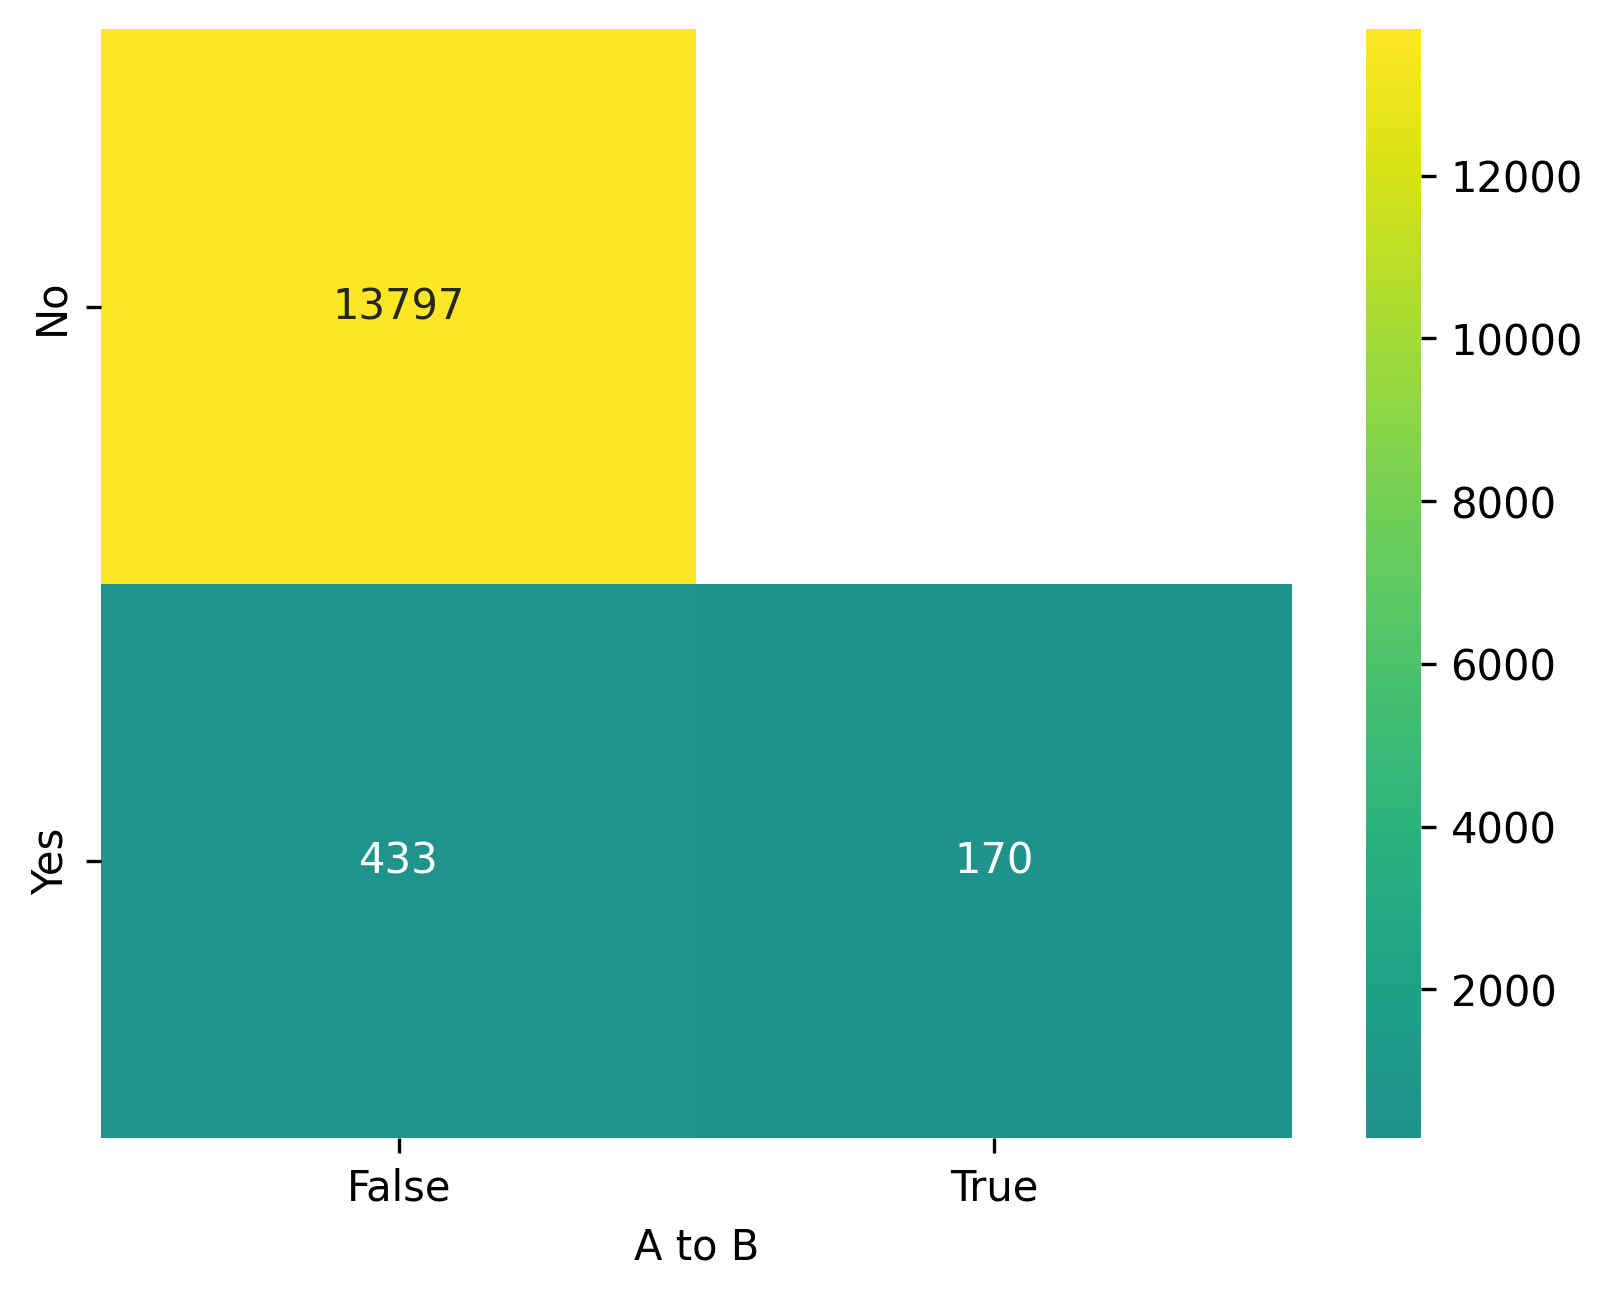

In [124]:
# create 2x2 heatmap of flipped_to_control and A_to_B, add False True to the heatmap 
test_group = steering_results.groupby(['flipped_to_control', 'A_to_B'])['A_to_B'].count()
test_group = test_group.unstack()
test_group.columns = ['False', 'True']
test_group.index = ['No', 'Yes']
sns.heatmap(test_group, annot=True, cmap='viridis', center=0.5, fmt='.0f')
plt.xlabel('A to B')

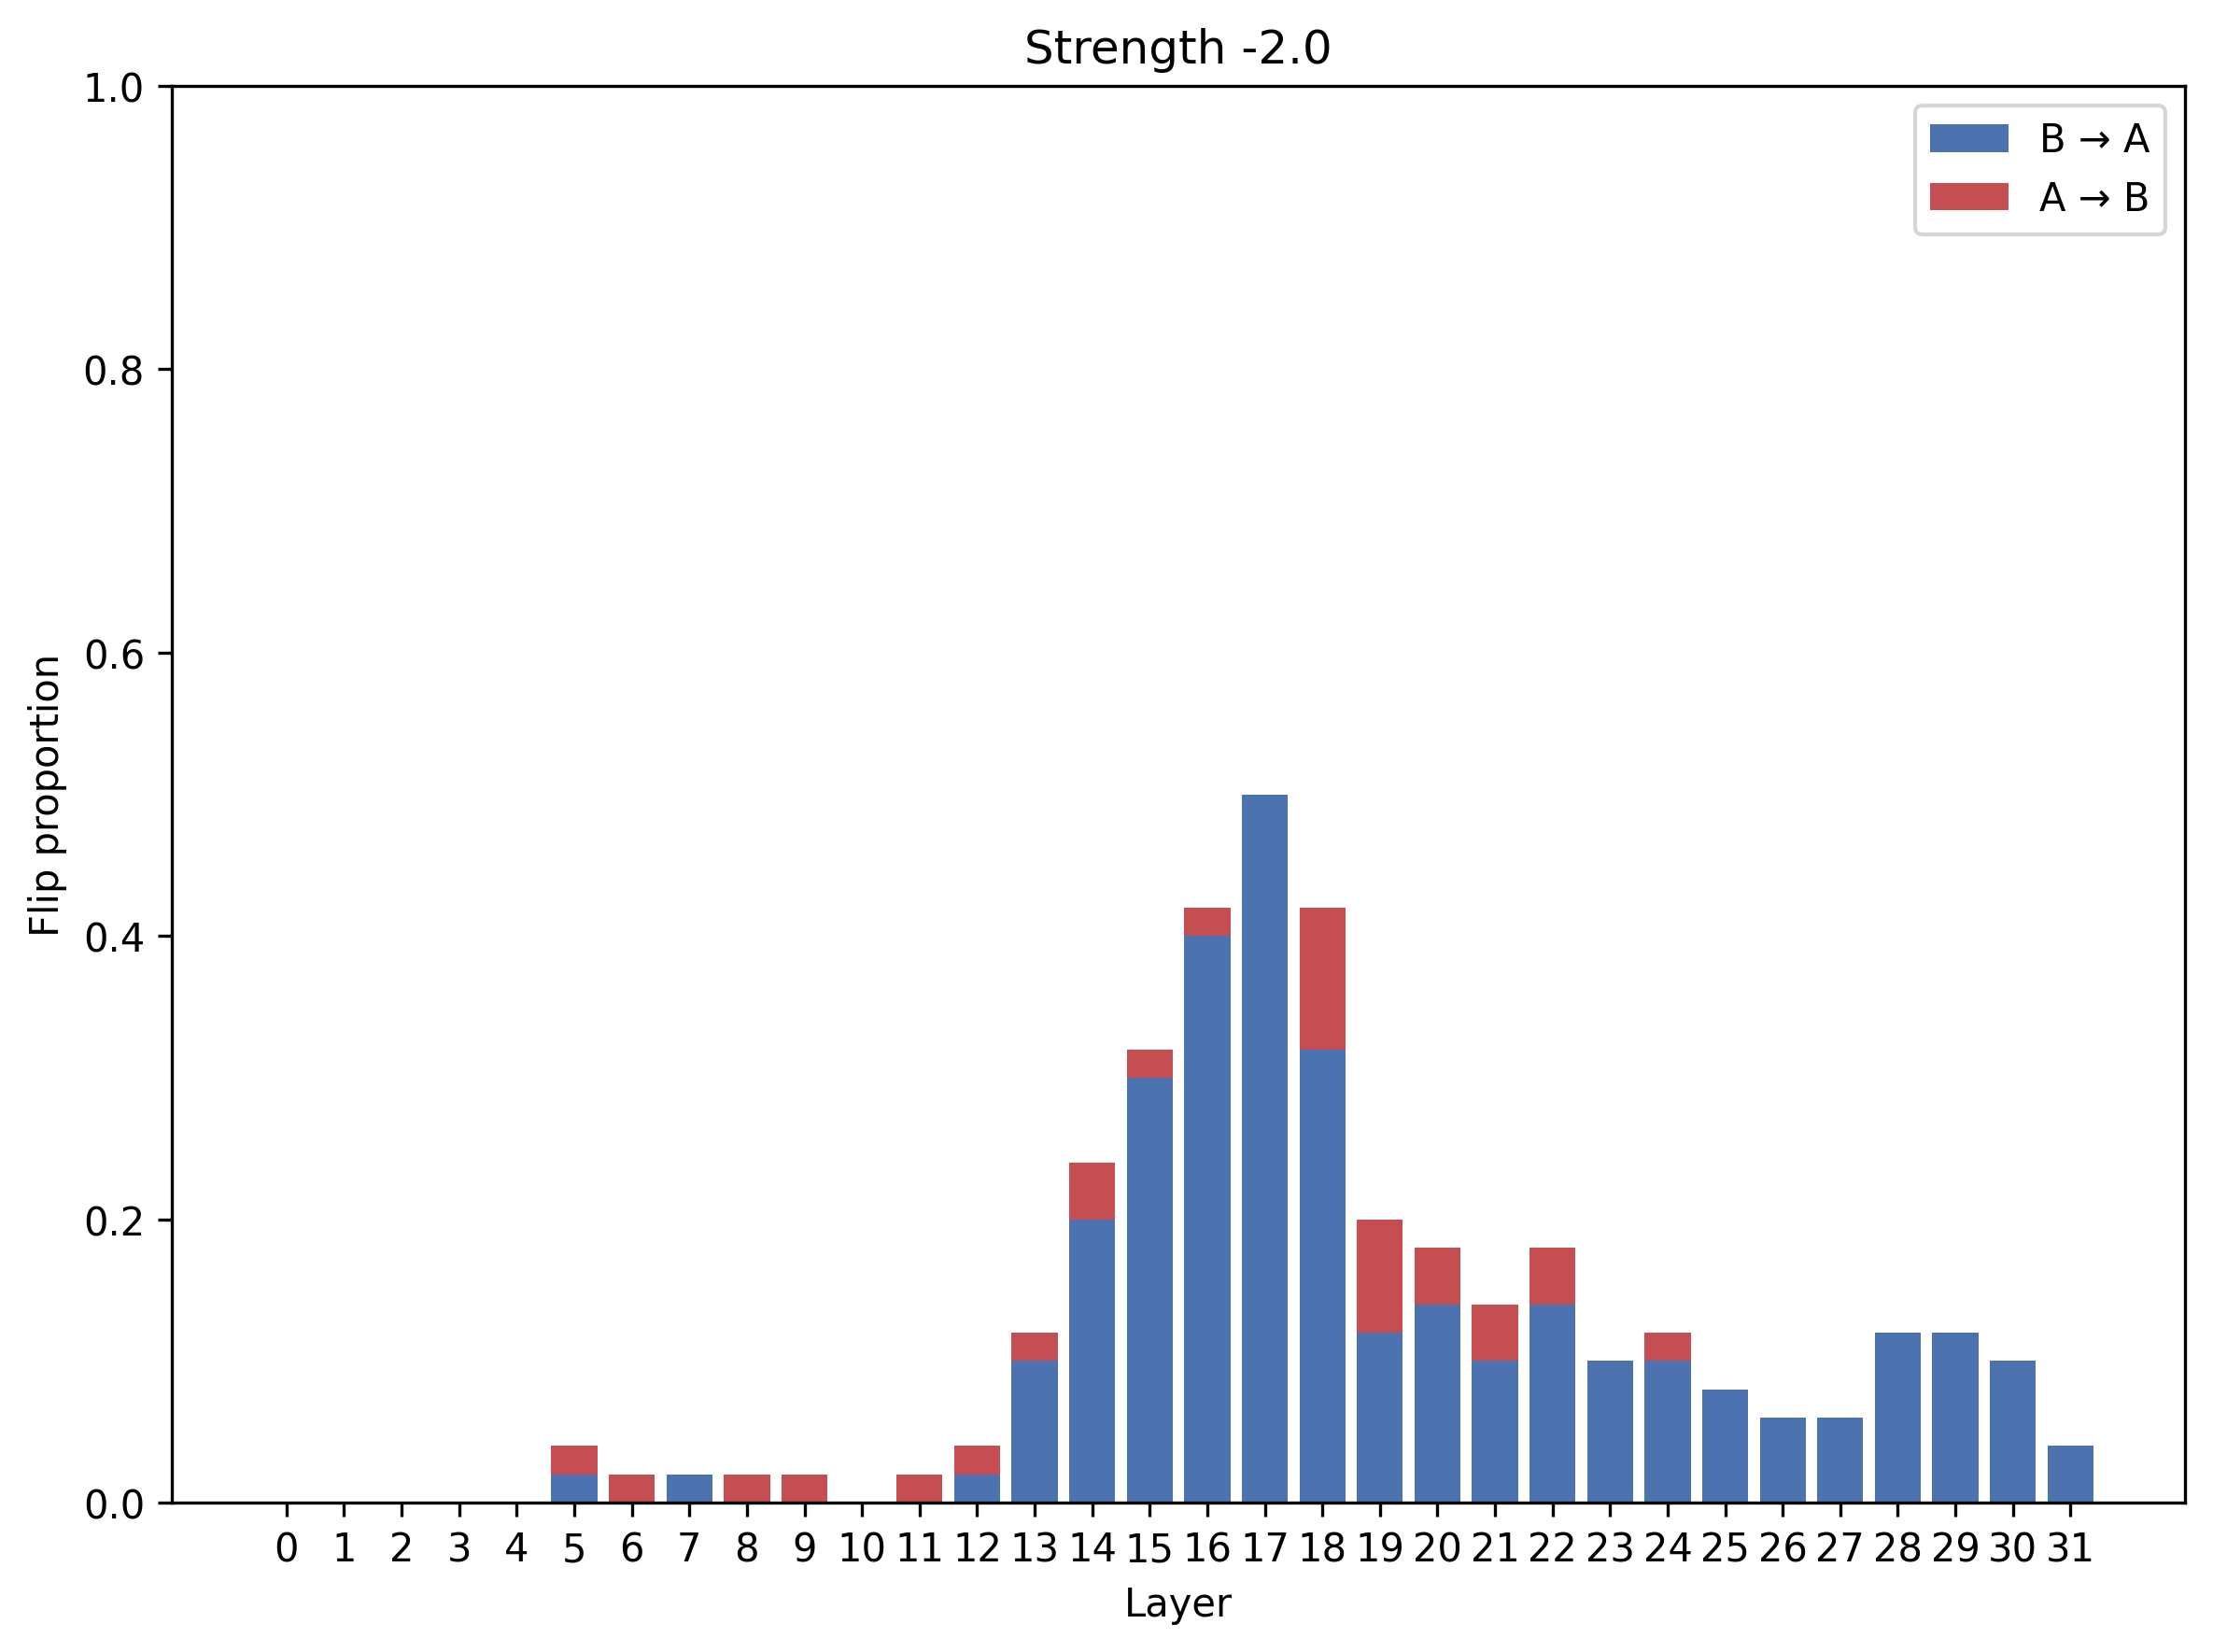

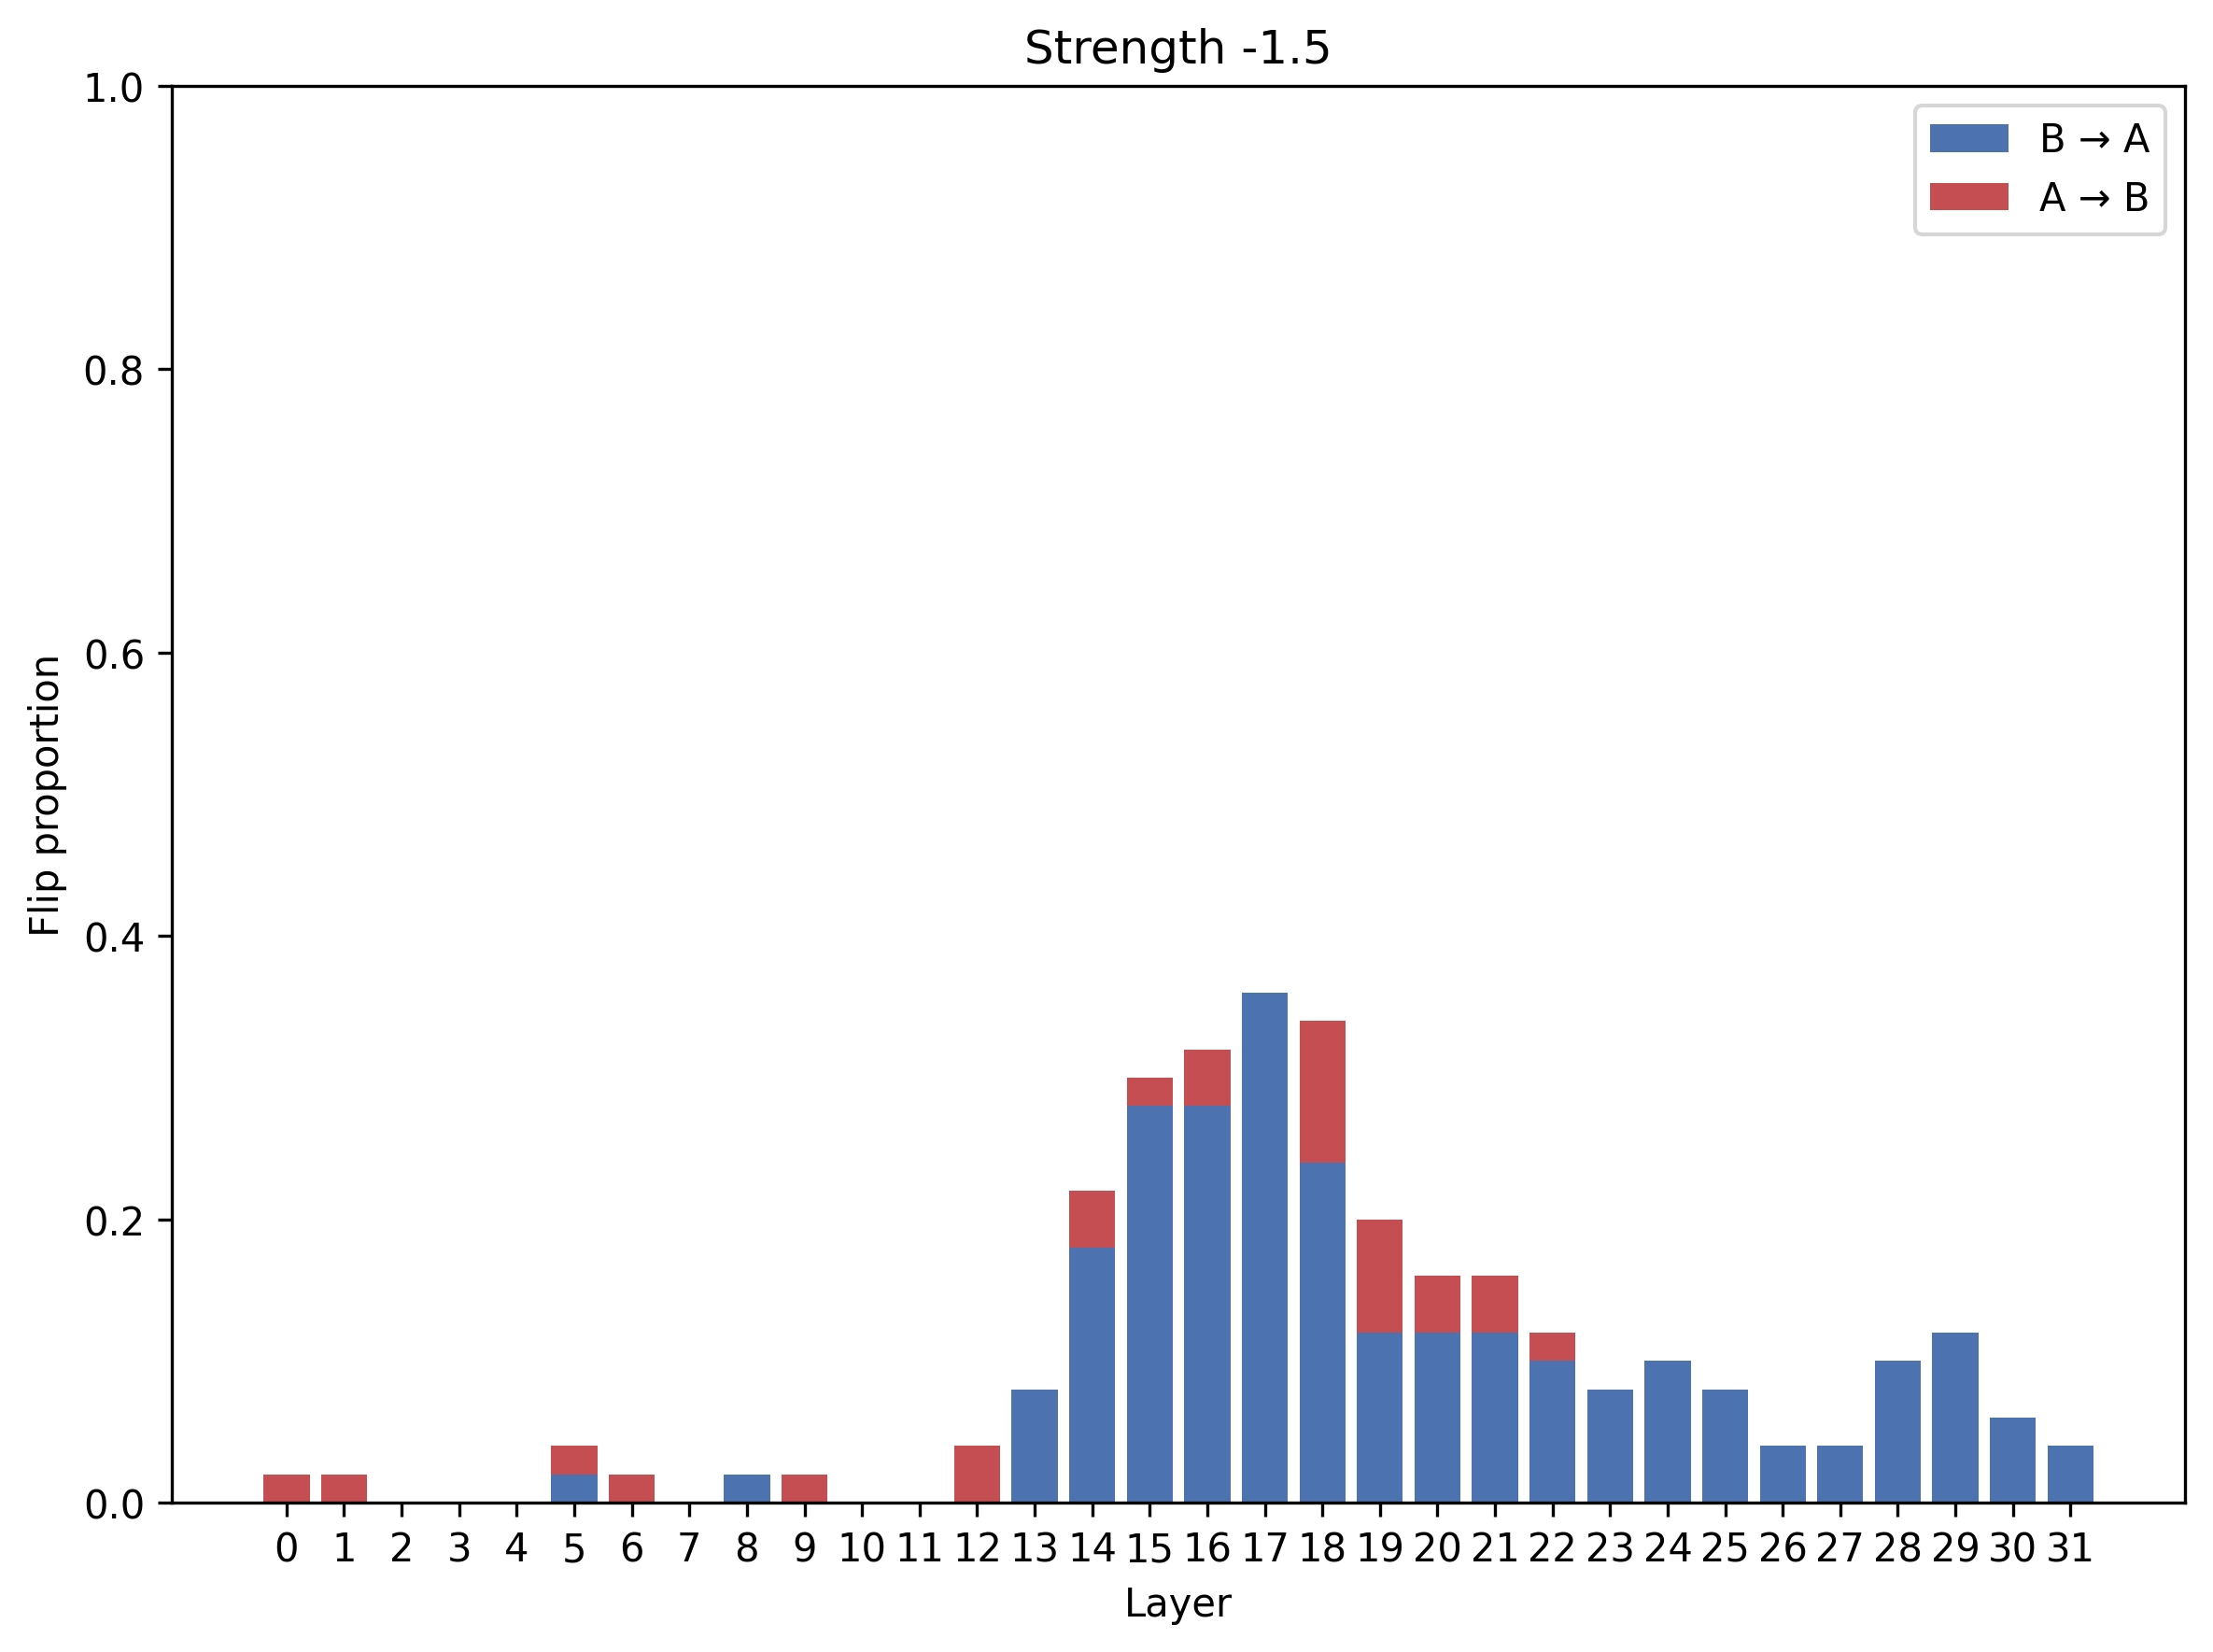

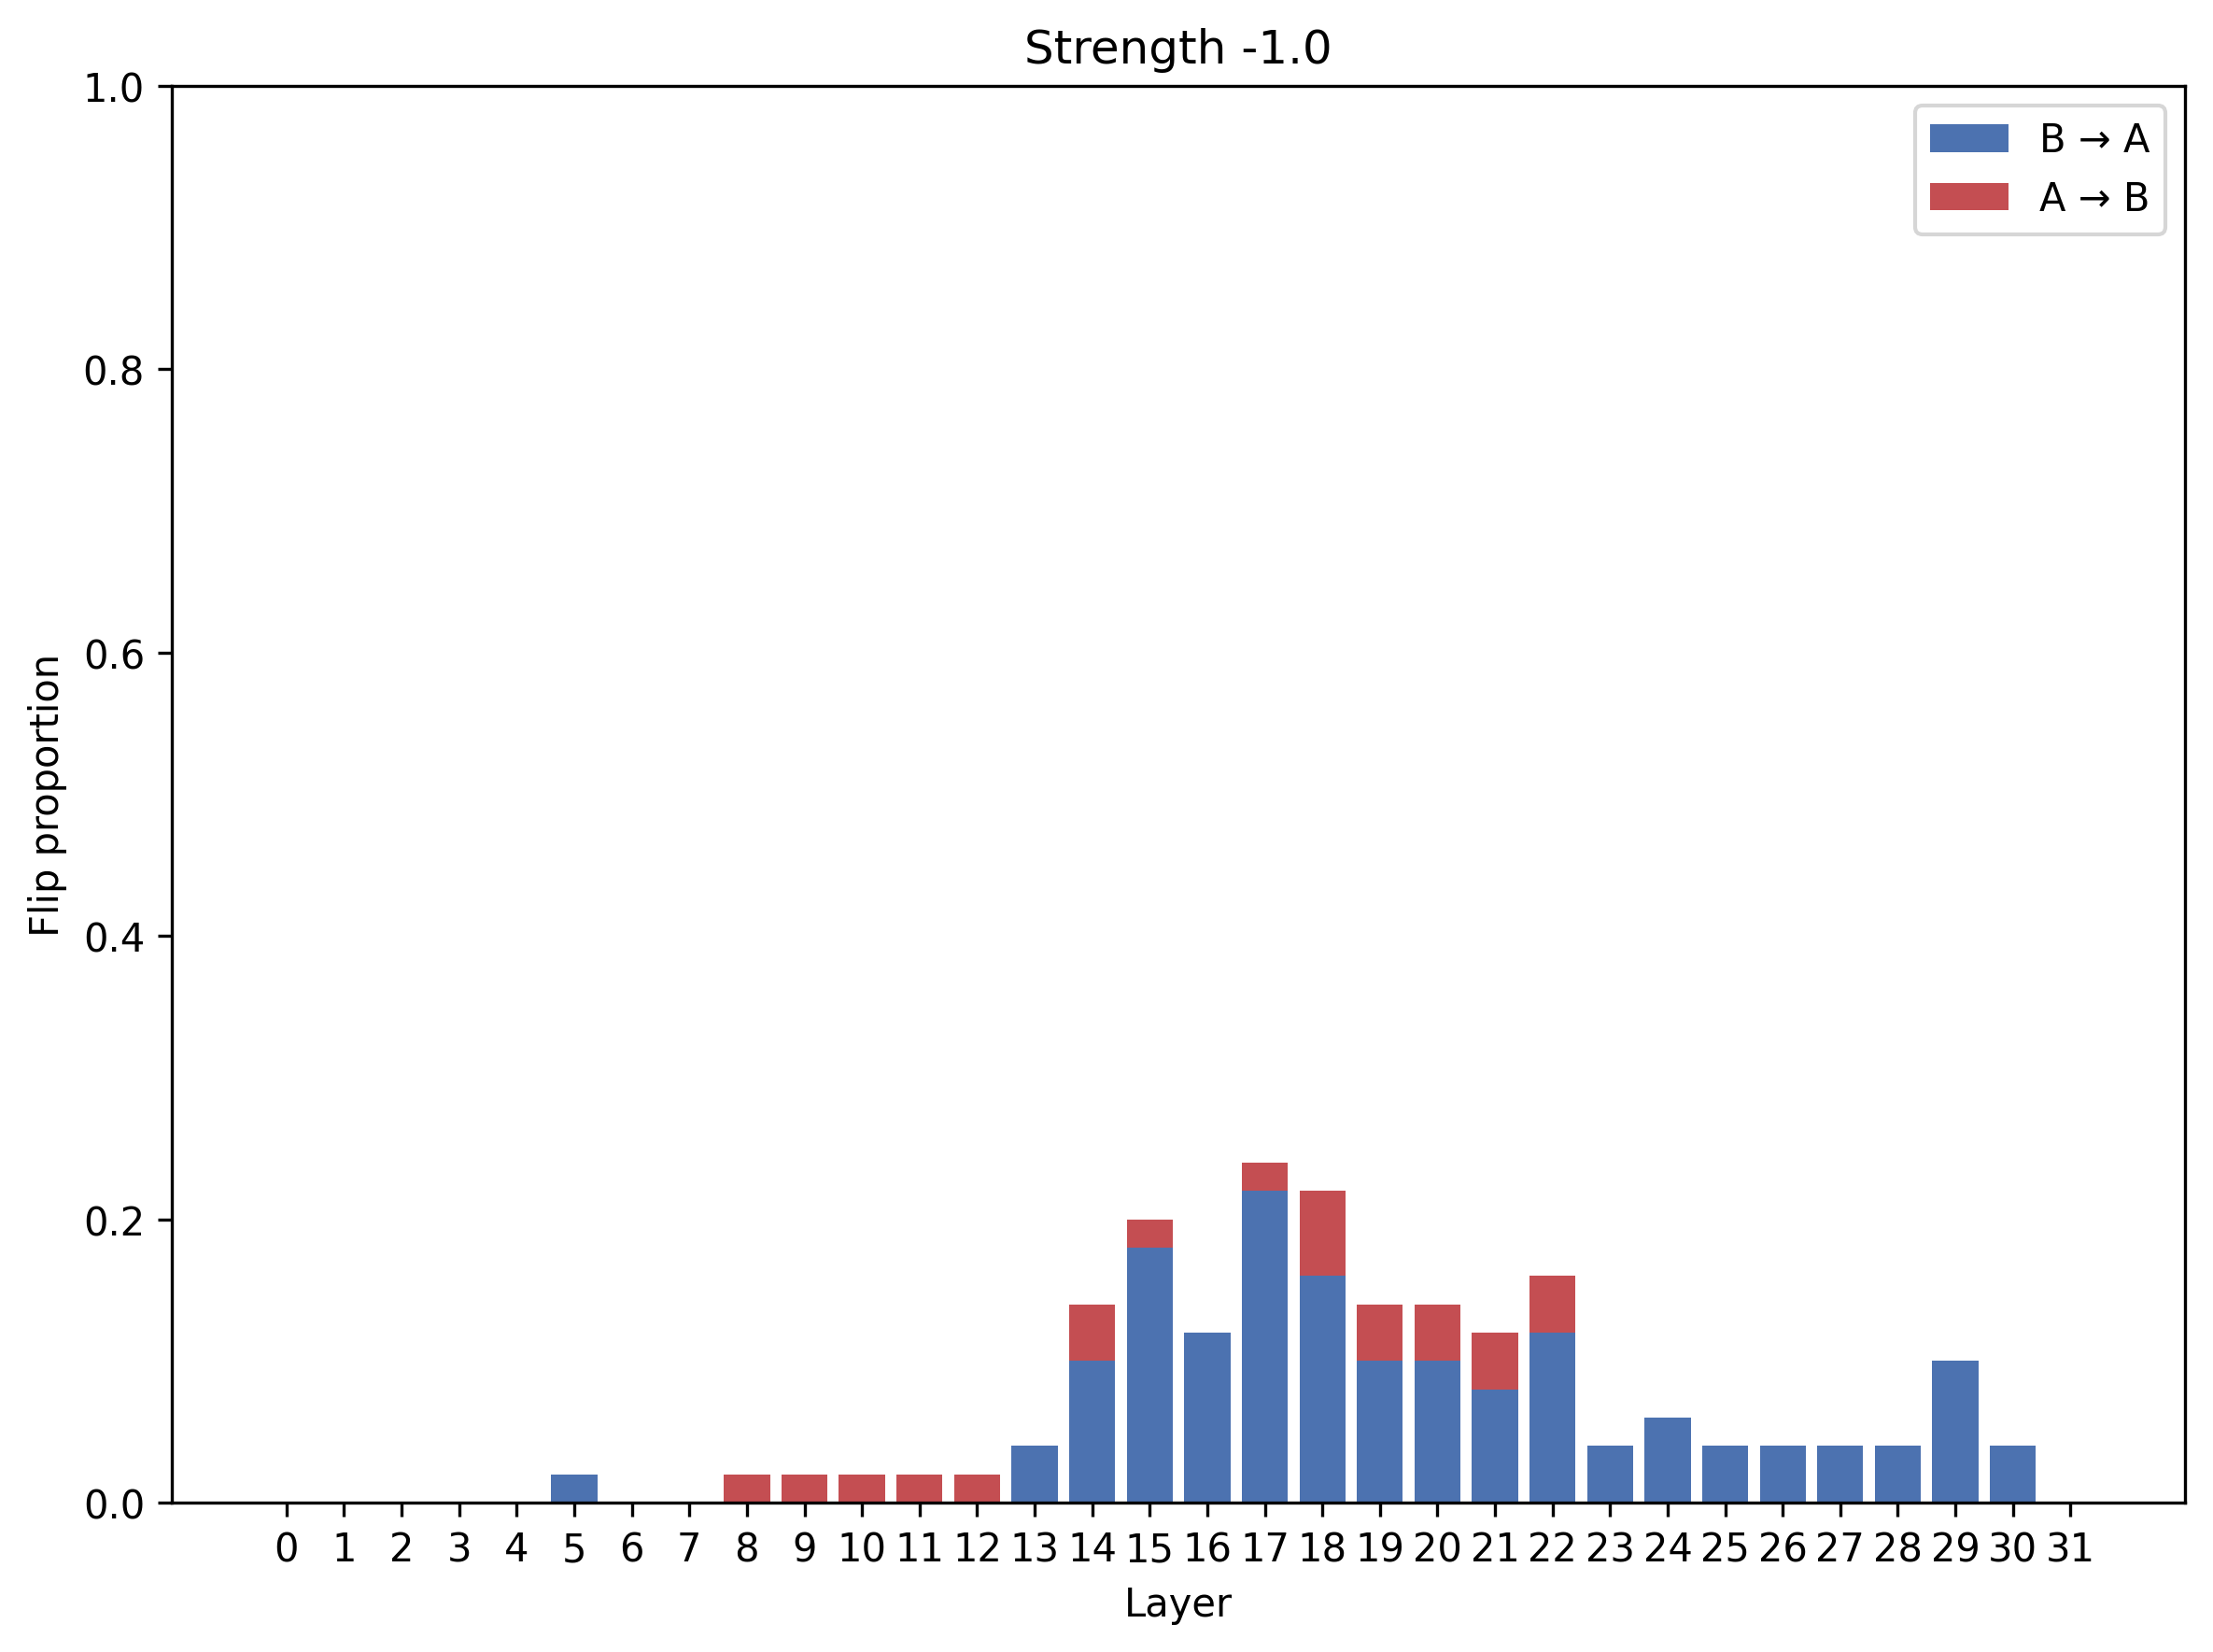

In [131]:
for i in [-2.0, -1.5, -1.0]:

    letter_flip_prop = steering_results[steering_results['strength'] == i].groupby(['layer']).agg({'flipped_to_control': 'sum', 'A_to_B': 'sum', 'treatment_text': 'count'})
    letter_flip_prop['flip_prop'] = letter_flip_prop['flipped_to_control'].astype(float) / letter_flip_prop['treatment_text']
    letter_flip_prop['flip_prop_B_to_A'] = (letter_flip_prop['flipped_to_control'] - letter_flip_prop['A_to_B']) / letter_flip_prop['treatment_text']

    fig, ax = plt.subplots(figsize=(8, 6))

    layers = letter_flip_prop.index
    ax.bar(layers, letter_flip_prop['flip_prop_B_to_A'], label='B → A', color='#4c72b0')
    ax.bar(layers, letter_flip_prop['flip_prop'] - letter_flip_prop['flip_prop_B_to_A'], bottom=letter_flip_prop['flip_prop_B_to_A'], label='A → B', color='#c44e52')

    ax.set_ylim(0, 1)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Flip proportion')
    ax.set_title(f'Strength {i}')
    ax.set_xticks(layers)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [96]:
df_switch_test[['control_resp','treatment_resp']].value_counts()

control_resp  treatment_resp
A             B                 25
B             A                 25
Name: count, dtype: int64

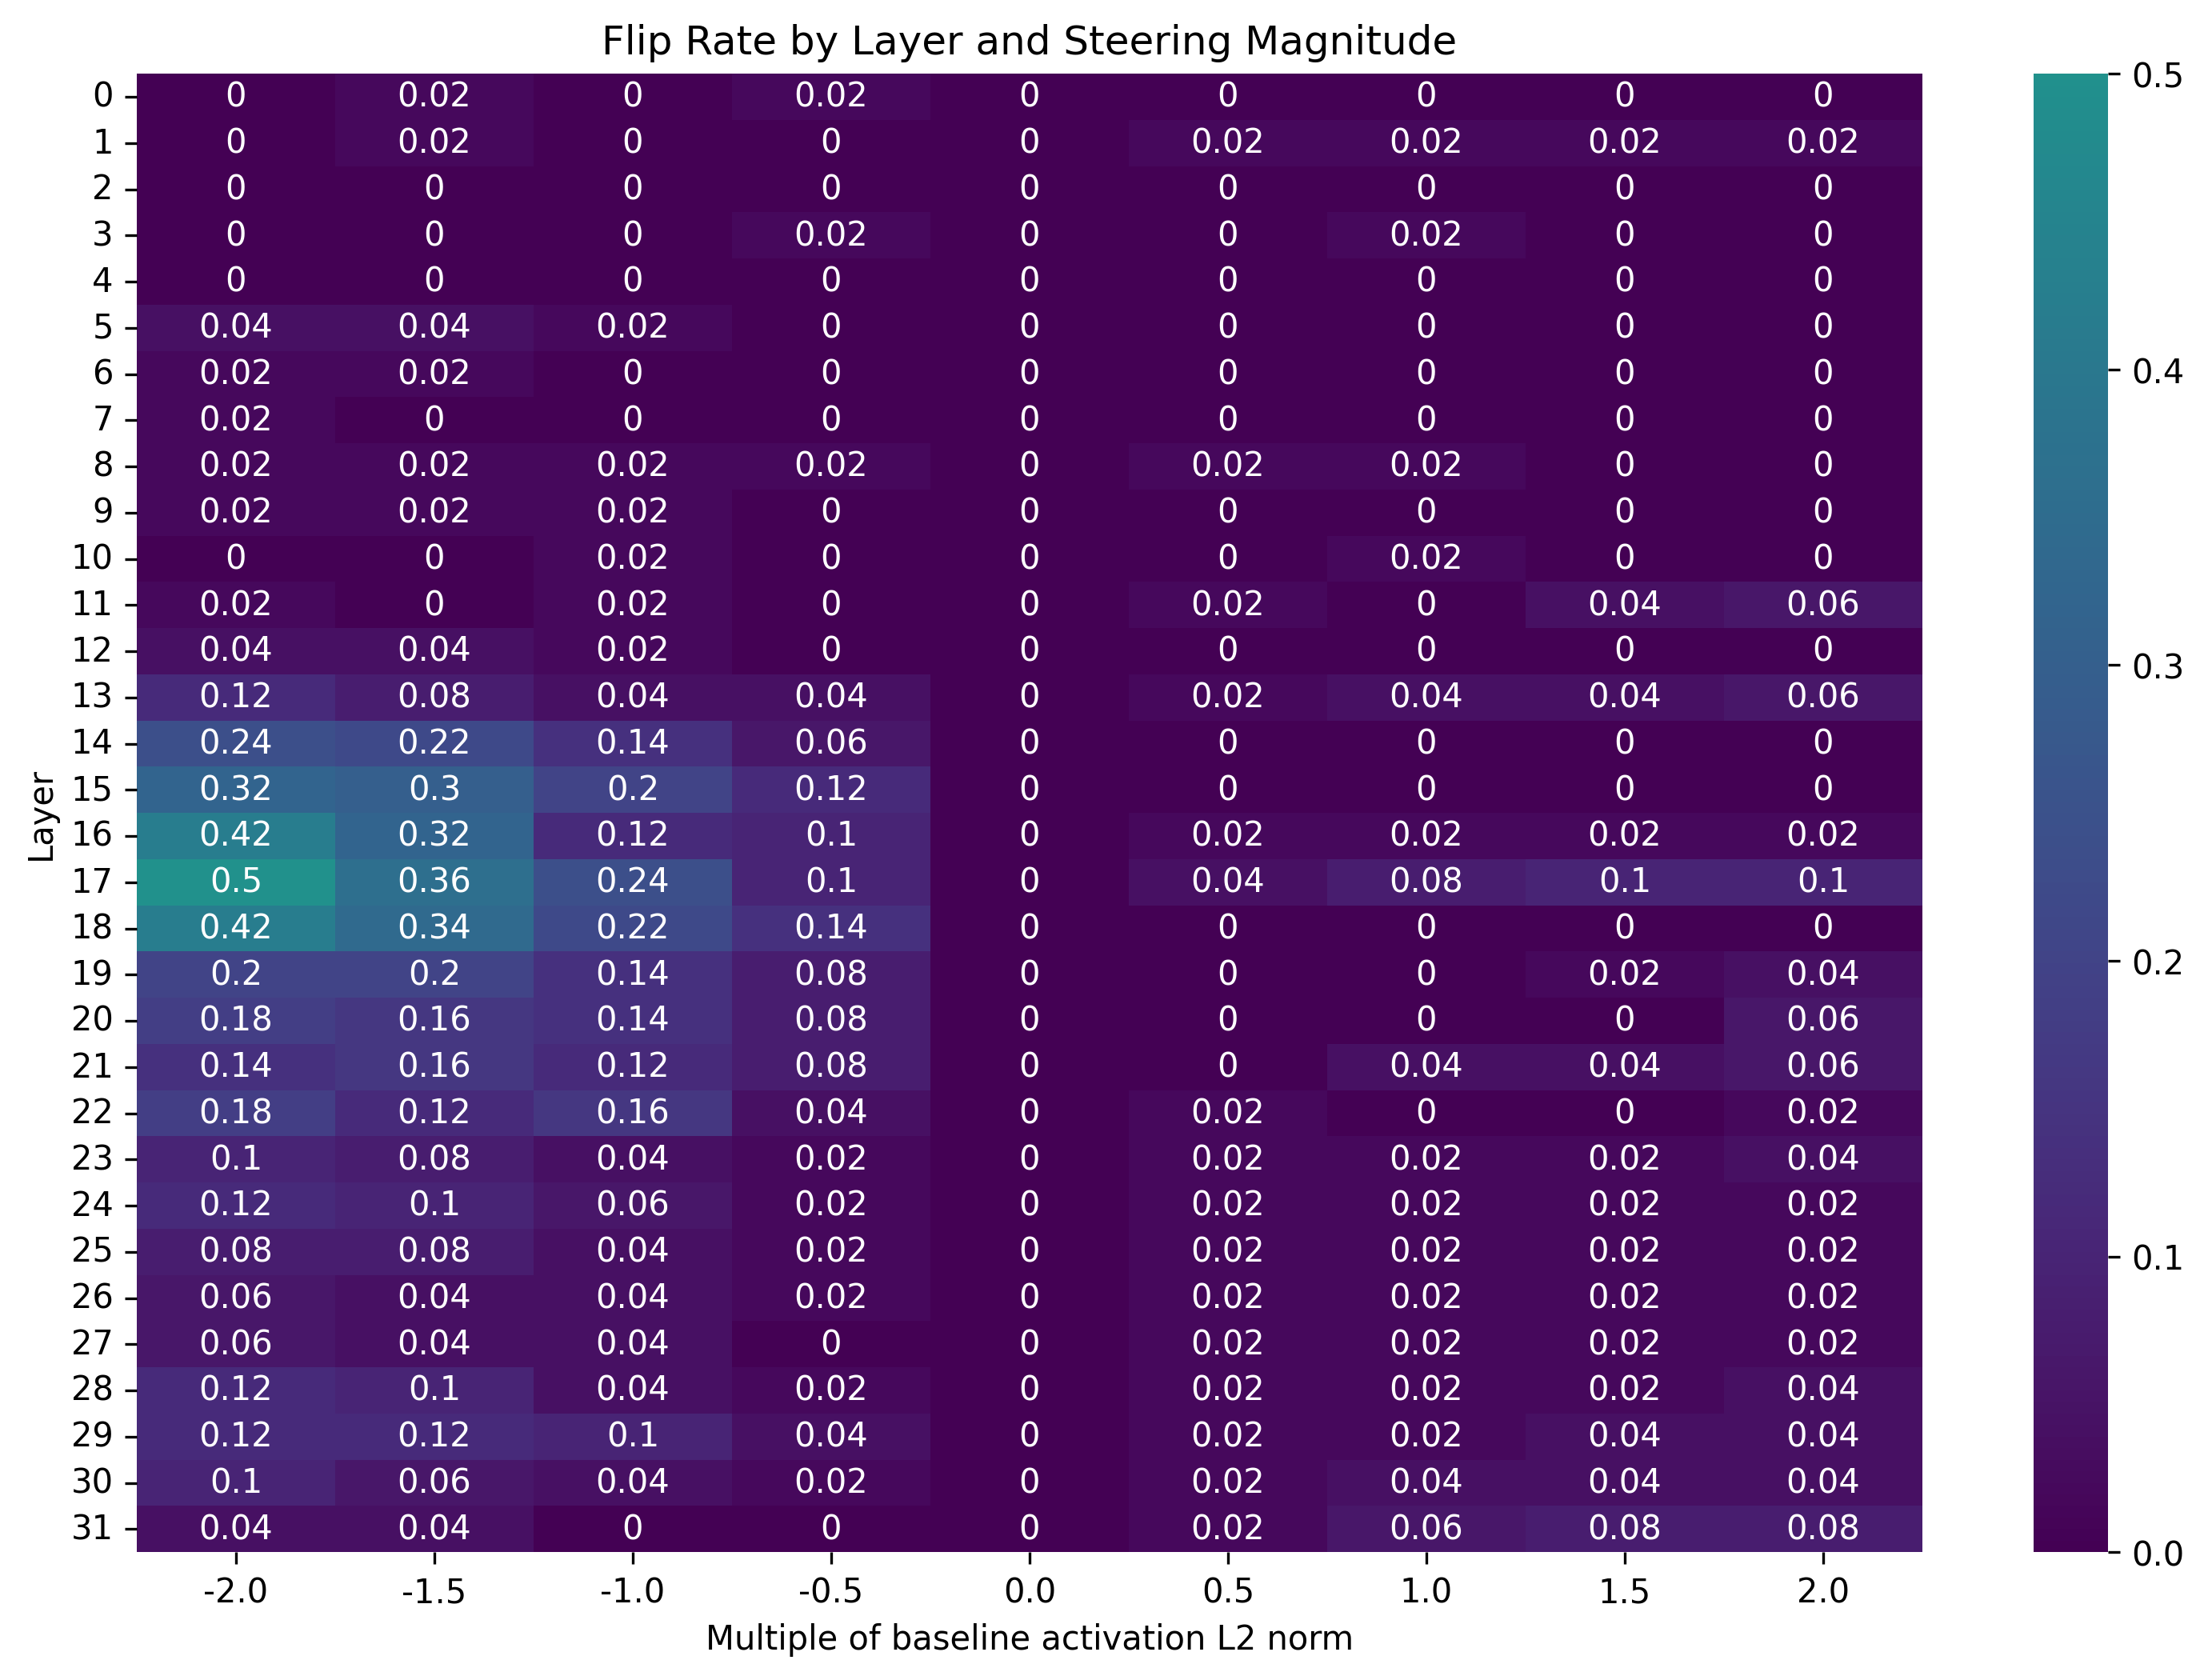

In [74]:
# create heatmap of flip rate by layer and strength
plt.figure(figsize=(12, 8))
sns.heatmap(steering_heatmap, annot=True, cmap='viridis', center=0.5)
plt.title('Flip Rate by Layer and Steering Magnitude')
plt.yticks(rotation=0)
plt.xlabel('Multiple of baseline activation L2 norm')
plt.ylabel('Layer')
plt.show()